In [1]:
use_R = True

In [3]:
import random
import itertools
import scipy

import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
import hnoca.utils as glyco
import gseapy as gp

#import hnoca.stats as stats
#import hnoca.map as mapping

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
from scipy.stats import mannwhitneyu

if use_R == True:
    import rpy2.rinterface_lib.callbacks
    import logging
    from rpy2.robjects import pandas2ri
    import rpy2.robjects as robjects
    import anndata2ri

    pandas2ri.activate()
    anndata2ri.activate()
    %load_ext rpy2.ipython

    %R library(edgeR)

During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 
/scratch/30728543/ipykernel_1274619/3226363883.py:30: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Loading required package: limma


In [4]:
plt.rcParams['figure.figsize']=(6,6)
sc.settings.verbosity = 3

plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [ ]:
def create_pseudobulk(adata, batch_column, replicates, matched, mode):
    import random

    adata.X = adata.layers['counts'].copy()

    smallest_n = round((min(adata.obs['dataset'].value_counts())) * 1.2)

    pbs = []
    
    for batch in adata.obs[batch_column].unique():
        print(f"processing {batch}")
        subset = adata[adata.obs[batch_column] == batch].copy()

        if matched == True:
            print(f"matching cell counts to {smallest_n}")
            # Match cell numbers to the target (e.g., 188 for Query)
            if subset.shape[0] > smallest_n:
                selected_indices = random.sample(list(subset.obs_names), smallest_n)
                subset = subset[selected_indices, :]
        else:
            print("not matching cell counts")

        indices = list(subset.obs_names)
        random.shuffle(indices)
        indices = np.array_split(np.array(indices), replicates)

        print(f"creating {replicates} pseudo-replicates")
        for i, pseudo_rep in enumerate(indices):
            rep_subset = subset[indices[i]].copy()
            rep_subset.obs['batch_rep'] = batch + '_' + str(i)
            rep_subset.obs['replicate'] = i

            pbs.append(rep_subset)

    pb = sc.concat(pbs)

    pb.X = pb.layers["counts"].copy()
    sc.pp.normalize_total(pb, target_sum=1e6)
    sc.pp.log1p(pb)
    pb.layers['lognorm'] = pb.X.copy()
    pb.obs["n_genes"] = (pb.X>0).sum(axis=1).A.ravel()
    
    print(f"creating pseudobulk using {batch_column} as sample_col\nand {mode} as mode")
    pdata = dc.get_pseudobulk(
        pb,
        sample_col=batch_column,
        groups_col='batch_rep',
        layer='counts',
        mode=mode,
        min_cells=10,
        min_counts=1000
    )

    pdata.X = np.round(pdata.X)
    pdata.obs["log_psbulk_counts"] = np.log(pdata.obs["psbulk_counts"])
    pdata.obs["n_genes_median"] = pdata.obs['batch_rep'].map(pb.obs.groupby('batch_rep')["n_genes"].median())
    pdata.obs["n_genes_std"] = pdata.obs['batch_rep'].map(pb.obs.groupby('batch_rep')["n_genes"].std())

    pdata.X = np.int32(pdata.X)

    dc.plot_psbulk_samples(pdata, groupby=[batch_column, 'n_genes_median'], figsize=(12, 4))

    return pdata


In [ ]:
def enrichr(glist, background, save_title, sample, gene_set="GO_Biological_Process_2021", nterms=10):
    res = gp.enrichr(
        gene_list=list(glist),
        gene_sets=[gene_set],
        outdir="enrichr/",
        no_plot=True,
        cutoff=0.05,
        background=background
    ).results.sort_values("Adjusted P-value", ascending=True)

    print(len(glist), "de genes")
    full_res = res.copy()
    res = res[res["Adjusted P-value"] < 0.05]
    if res.empty:
        print("no significant results")
        return
    res["-log10(qvalue)"] = -np.log(res["Adjusted P-value"])
    res["term_clean"] = res["Term"].str.split(" \(").str[0]
    ax = res.set_index("term_clean").iloc[:nterms]["-log10(qvalue)"].plot(kind="barh")
    ax.axvline(-np.log(0.05), ls="--", c="#000000")
    ax.invert_yaxis()
    plt.xlabel("-log10(qvalue)")
    plt.ylabel("GO-BP")
    plt.savefig(f'/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/figures/03d_transcriptomic_fidelity/enrichr_{save_title}_{sample}.pdf', bbox_inches="tight")
    plt.show()
    return full_res

In [ ]:
def get_sig_results(results, qval_thres=0.05, lfc_abs_thres=0.5):
    results_cleaned = {}
    results_up = {}
    results_down = {}

    for k in results.keys():
        # Filter for significant results based on q-value and log2 fold change threshold
        filtered = results[k].loc[results[k]["qval"] < qval_thres].copy()
        filtered = filtered.loc[filtered["log2fc_abs"] > lfc_abs_thres].copy()

        # Store the bidirectional (both up and down) results
        results_cleaned[k] = filtered

        # Store the upregulated results
        results_up[k] = filtered.loc[filtered["log2fc"] > 0.0].copy()

        # Store the downregulated results
        results_down[k] = filtered.loc[filtered["log2fc"] < 0.0].copy()

    return results_cleaned, results_up, results_down

In [ ]:
def get_deg_overlap(results_cleaned, comparisons=['HDBCA_vs_Query', 'HDBCA_vs_HNOCA']):
    """
    Extract shared DEGs (aligned by log2FC direction) and unique DEGs for the specified comparisons.

    Args:
        results_cleaned (dict): A dictionary where keys are comparisons (e.g., 'Query_vs_HDBCA')
                                and values are DataFrames containing 'log2fc'.
        comparisons (list): A list of comparison keys to use. Default is ['HDBCA_vs_Query', 'HDBCA_vs_HNOCA'].

    Returns:
        shared_aligned_degs (dict): Subsets of results_cleaned DataFrames for shared DEGs with aligned log2FC
                                    directions, keyed by comparison name.
        unique_degs (dict): Subsets of results_cleaned DataFrames for genes unique to each comparison,
                            keyed by comparison name.
    """
    # Extract sets of genes for each comparison
    results_sets = {}
    for k in comparisons:
        if k in results_cleaned:
            if isinstance(results_cleaned[k], pd.DataFrame):
                results_sets[k] = set(results_cleaned[k].index)
            else:
                results_sets[k] = set(results_cleaned[k])
        else:
            raise ValueError(f"Key '{k}' not found in results_cleaned.")

    # Ensure there are at least two comparisons
    if len(results_sets) < 2:
        raise ValueError(f"At least two comparisons must be provided. Found {len(results_sets)} comparisons.")
    
    # Get shared and unique genes for each comparison
    shared_genes = set.intersection(*results_sets.values())  # Genes shared in all comparisons
    unique_degs = {k: sorted(results_sets[k] - set(shared_genes)) for k in comparisons}  # Unique genes for each comparison
    
    # Filter shared genes by log2FC alignment (same direction across all comparisons)
    shared_aligned_degs_genes = []
    for gene in shared_genes:
        log2fc_values = {k: results_cleaned[k].loc[gene, 'log2fc'] for k in comparisons}
        
        # Check if all comparisons have the same log2FC direction (either both positive or both negative)
        if all(val > 0 for val in log2fc_values.values()) or all(val < 0 for val in log2fc_values.values()):
            shared_aligned_degs_genes.append(gene)

    # Create DataFrame subsets for shared DEGs
    shared_aligned_degs = {
        k: results_cleaned[k].loc[shared_aligned_degs_genes]
        for k in comparisons
    }
    
    # Create DataFrame subsets for unique DEGs
    unique_degs = {
        k: results_cleaned[k].loc[unique_degs[k]]
        for k in comparisons
    }

    return shared_aligned_degs, unique_degs


In [ ]:
%%R

edger_fit <- function(pdata){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(pdata, "X"), group = colData(pdata)$dataset)
    # filter out genes with low counts
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    y <- calcNormFactors(y)
    # create a design matrix
    design <- model.matrix(~ colData(pdata)$dataset)
    colnames(design) <- sub(".*\\$", "", colnames(design))
    y <- estimateDisp(y, design = design)
    fit <<- glmQLFit(y, design)
    print(colnames(fit))
    return("success")
}

edger_test <- function(coef=NULL, contrast=NULL) {
    if (!is.null(contrast)) {
        print(contrast)
        # Create contrast matrix and test using glmQLFTest
        contrast <<- contrast
        contrast_matrix <- makeContrasts(contrast, levels=fit$design)
        test <- glmQLFTest(fit, contrast=contrast_matrix)
    } else {
        # Default testing using the provided coefficient
        print(coef)
        test <- glmQLFTest(fit, coef=coef)
    }
    tt <- topTags(test, n=Inf)
    return(tt$table)
}

In [ ]:
r_edger_fit = robjects.globalenv['edger_fit']
r_edger_test = robjects.globalenv['edger_test']

def edger_test(coef=None, contrast=None, plot=True):
    if contrast:
        print(f"Testing contrast: {contrast}")
    else:
        print(f"Testing coefficient: {coef}")
    
    if contrast:
        out = robjects.conversion.rpy2py(r_edger_test(contrast=contrast))
    else:
        out = robjects.conversion.rpy2py(r_edger_test(coef=coef))
    out.columns = ["log2fc", "logCPM", "F", "pval", "qval"]
    out = out[["pval", "qval", "log2fc", "logCPM", "F"]]
    out["log2fc_abs"] = out["log2fc"].abs()
    if plot:
        dc.plot_volcano_df(out, x='log2fc', y='qval', top=30, figsize=(8,8))
        plt.show()
    return out

In [5]:
annot_level_2_color = {
    'PSC':'#c2d6c2', #d5573b',
    'Radial glia':'#f2ae54', #ce336e',
    'Neuroepithelium':'#f5d1a3',
    'OPC':'#0077b6',#11b8ea
    'Pre-OPC':'#48cae4',#11b8ea
    'COP':'#03045e',#11b8ea
    'Neuron':'#006400', #38d373',
    'Neuroblast':'#38b000', #38d373',
    'Neuronal IPC':'#70e000', #38d373',
    #'OPC':'#ff7240', #9c4fff',
    'Glioblast':'#e01e37', #ffbe15',
    'Astrocyte':'#85182a', #2073ff',
    'Fibroblast':'#D3D3D3',
    'Neural crest':'#8c8c8c',
}

# Score glycolysis

In [6]:
query = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/BRO_RA1_exp023_annotated_integrated_final.h5ad')

In [7]:
query.X = query.layers['counts'].copy()

In [8]:
hnoca = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/HNOCA/hnoca_cleanedmeta.h5ad')

In [9]:
hnoca.X = hnoca.layers['counts_lengthnorm'].copy()

In [10]:
query.obs['publication'] = "This study"

In [11]:
adata = hnoca.concatenate([query])

In [12]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

normalizing counts per cell


    finished (0:00:44)


In [13]:
glyco.compute_glycolysis_score(adata)

computing score 'Hallmark_Glycolysis'


    finished: added
    'Hallmark_Glycolysis', score of gene set (adata.obs).
    988 total control genes are used. (0:02:34)


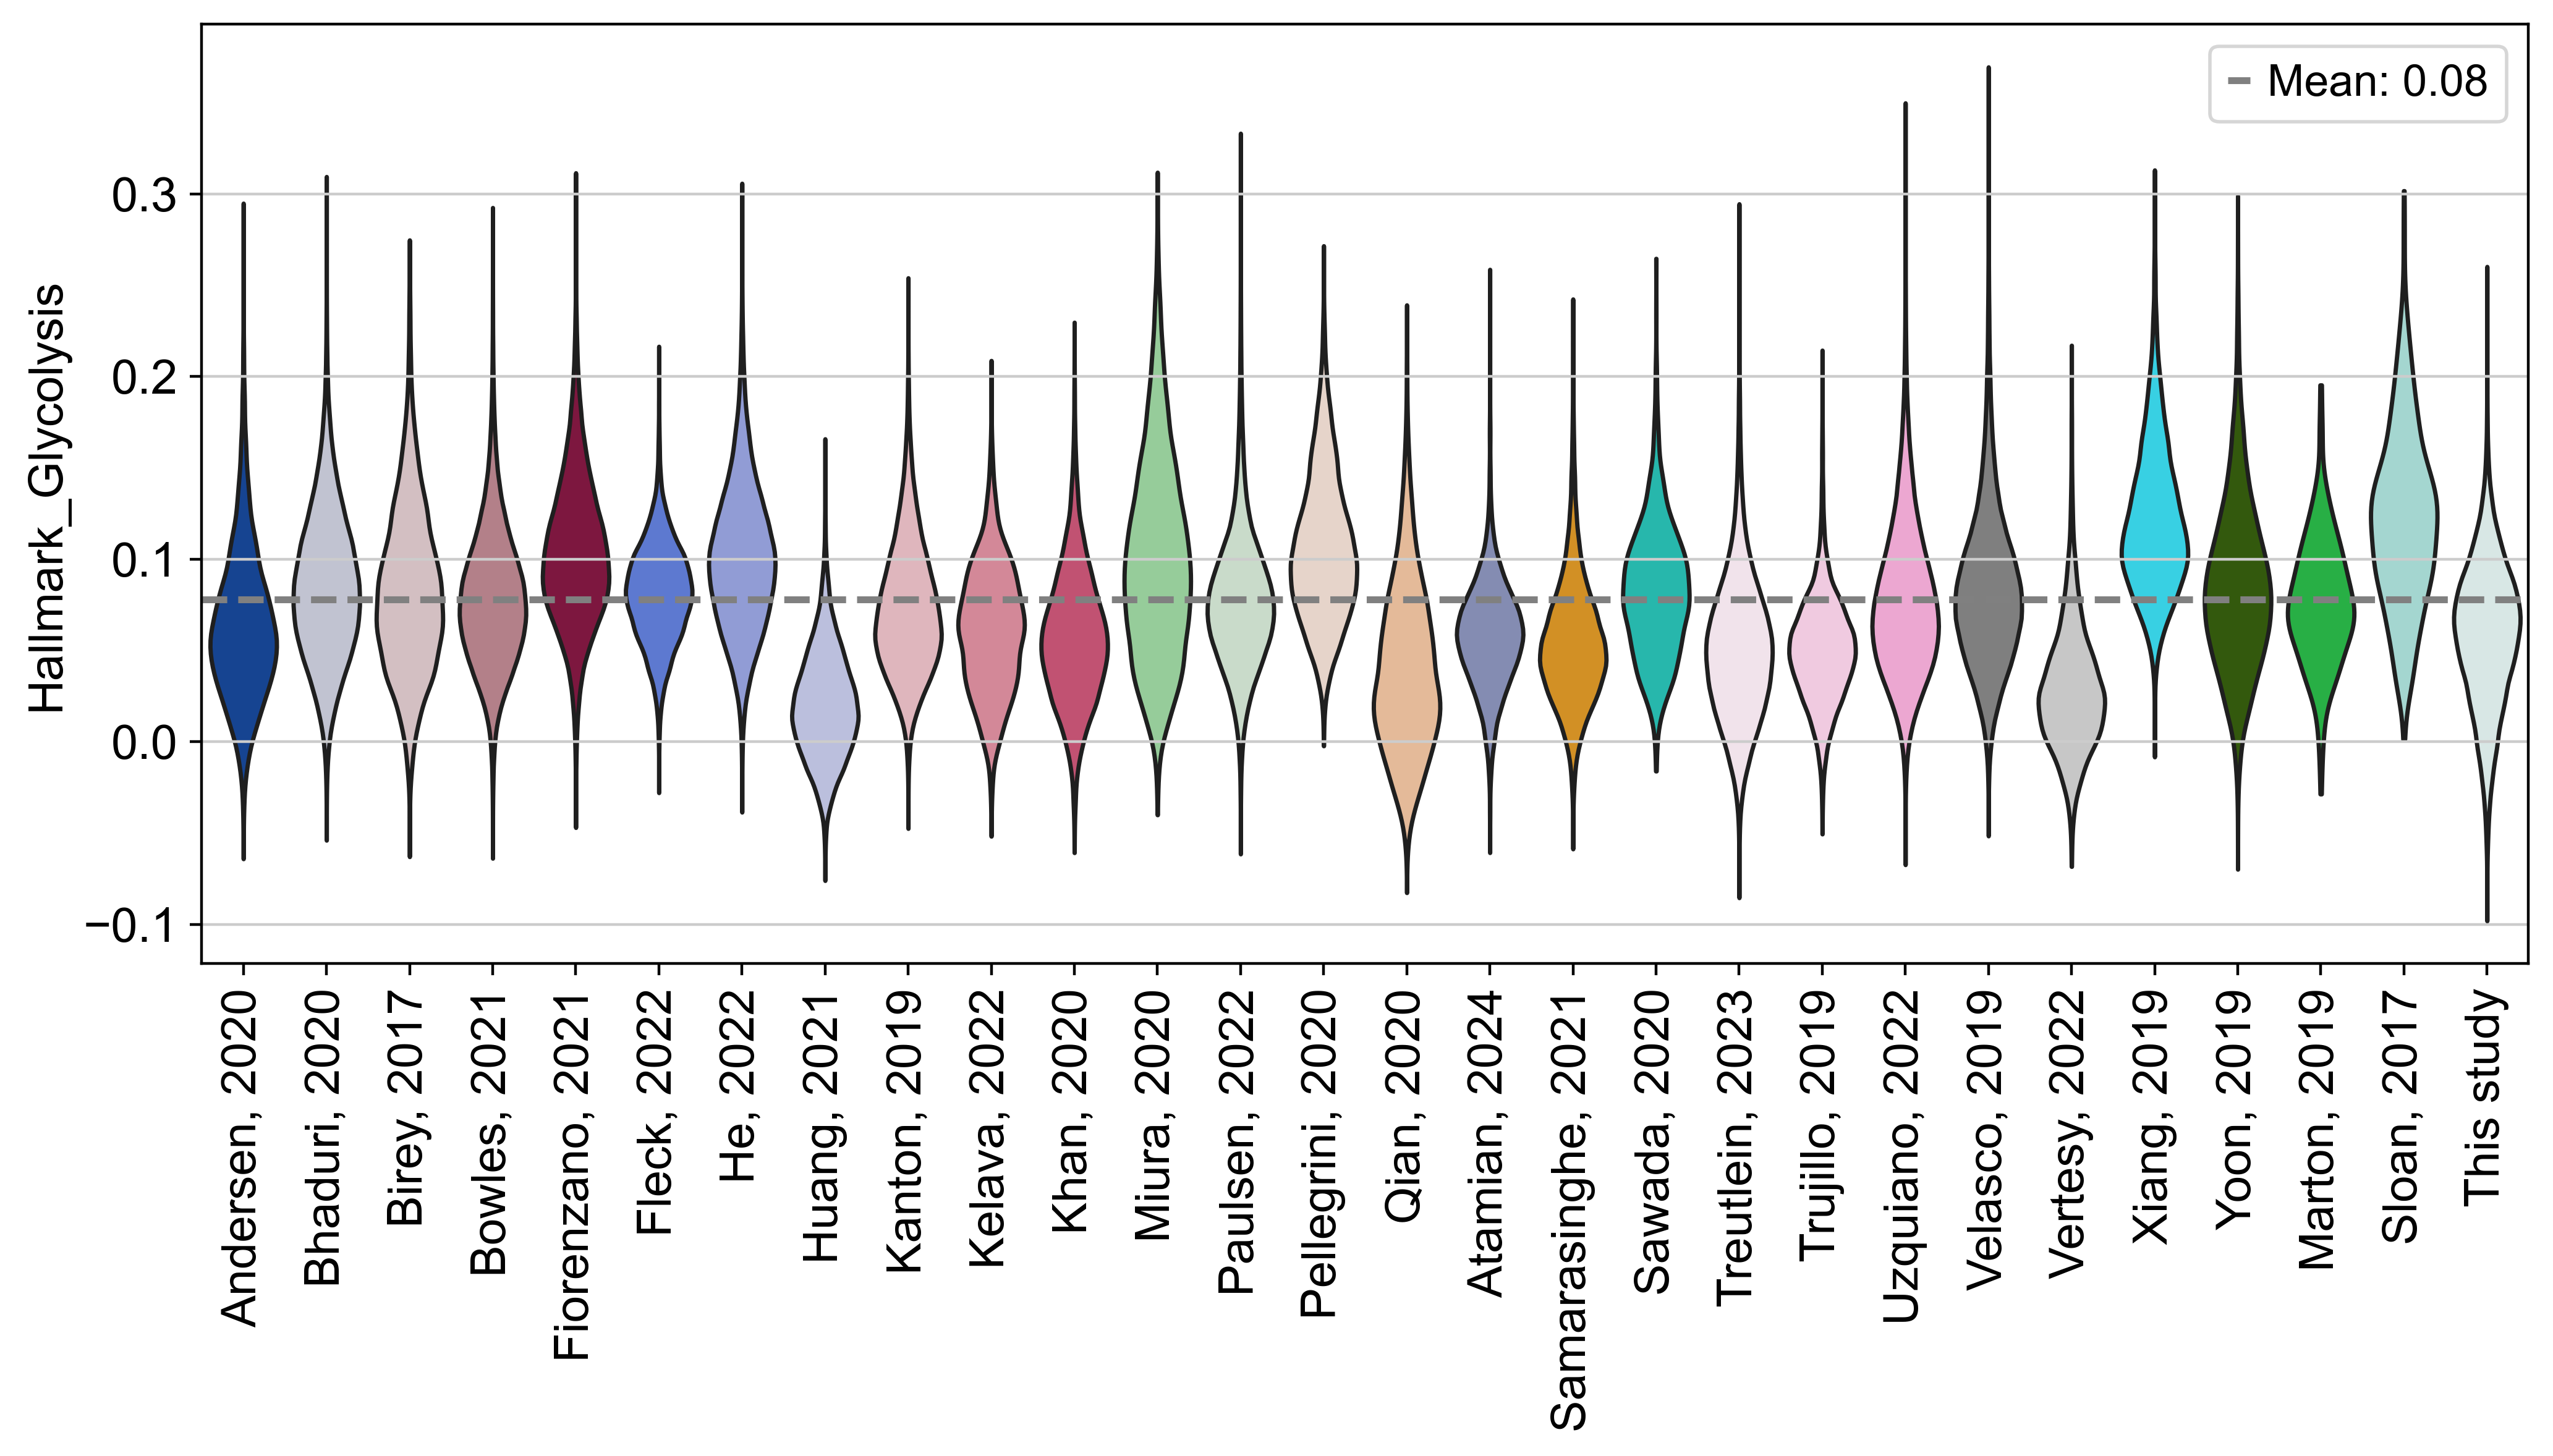

: 

In [14]:
order = list(hnoca.obs['publication'].unique()) + ["This study"]

plt.rcParams['figure.figsize']=(10,5)
# Draw the violin plot
ax = sc.pl.violin(adata, keys='Hallmark_Glycolysis', groupby='publication', log=False, rotation=90, order=order, stripplot=False, show=False)

# Calculate the mean value of the 'Hallmark_Glycolysis' data
mean_value = adata[adata.obs['publication']!="This study"].obs['Hallmark_Glycolysis'].mean()
# Add a dashed line at the mean value
plt.axhline(mean_value, color='grey', linestyle='--', linewidth=2, label=f"Mean: {mean_value:.2f}")
plt.legend()
plt.savefig('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/figures/03d_transcriptomic_fidelity/Glycolyis_violin_HNOCA.pdf', bbox_inches='tight')
plt.show()

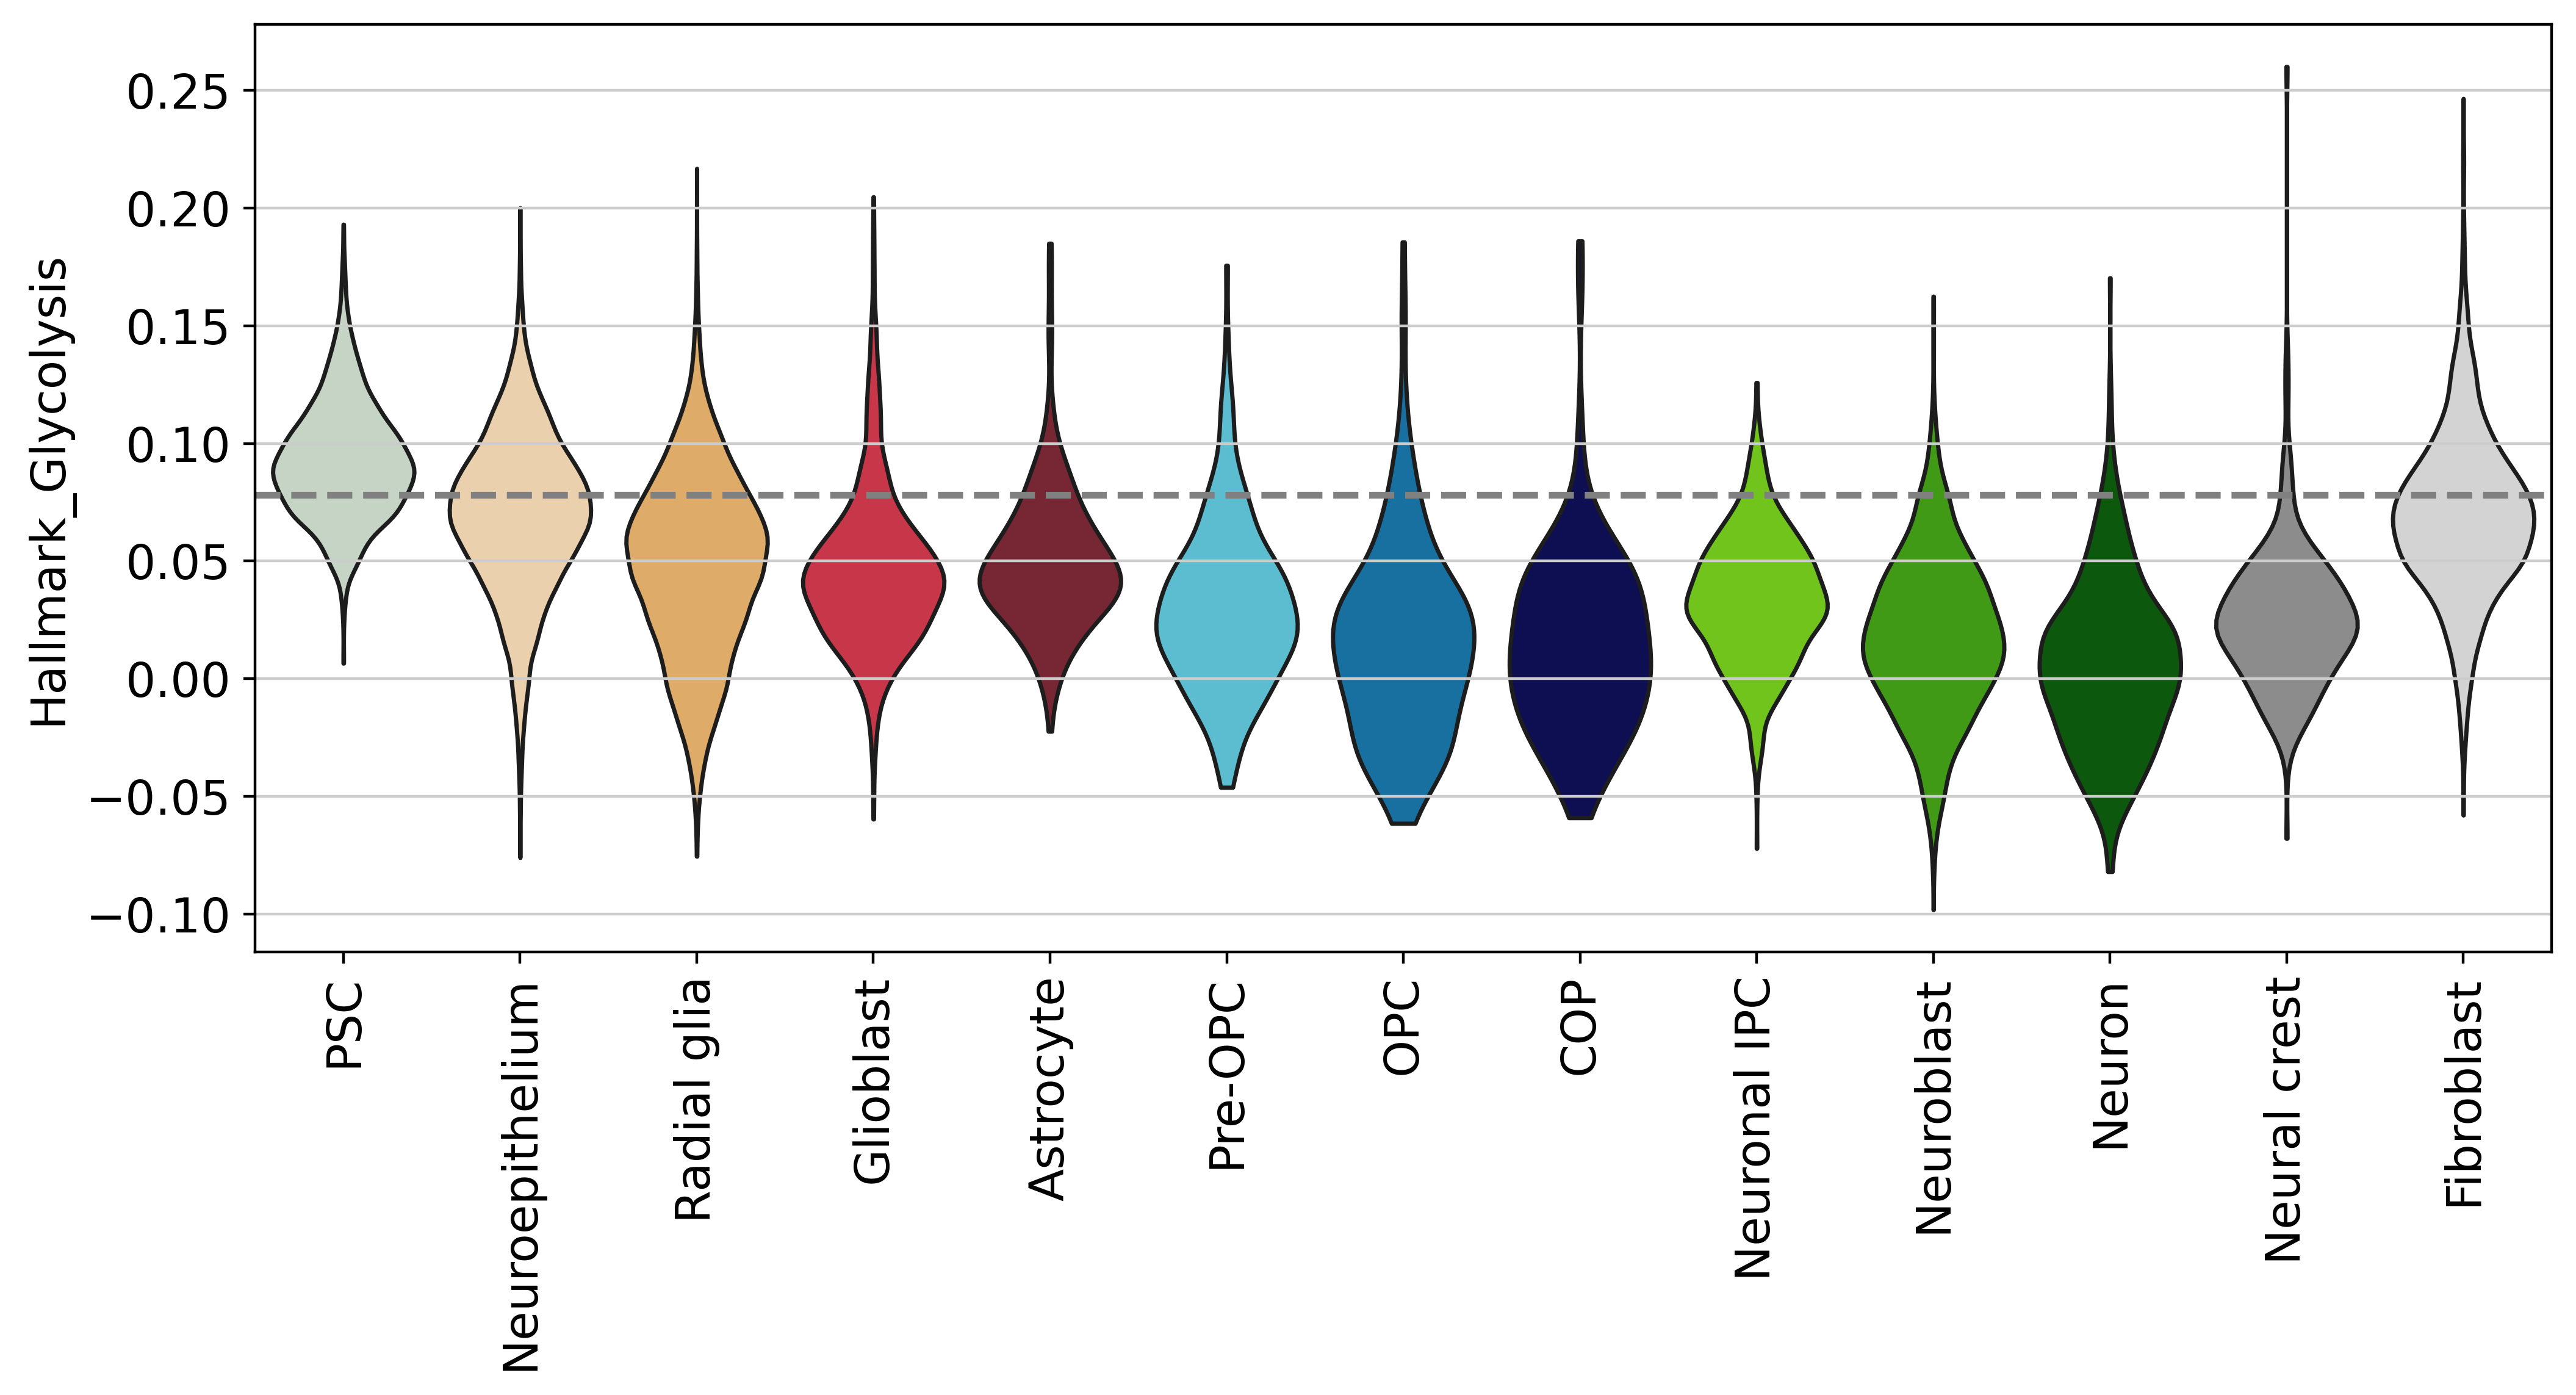

In [22]:
ax = sc.pl.violin(query, 
    keys="Hallmark_Glycolysis", 
    groupby="final_annot_level_2", 
    log=False, 
    rotation=90,
    palette=annot_level_2_color, 
    order=['PSC','Neuroepithelium','Radial glia','Glioblast','Astrocyte', 'Pre-OPC','OPC', 'COP', 'Neuronal IPC', 'Neuroblast', 'Neuron', 'Neural crest','Fibroblast'],
    stripplot=False,
    show=False
    )
plt.axhline(mean_value, color='grey', linestyle='--', linewidth=2)
plt.savefig('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/figures/03d_transcriptomic_fidelity/Glycolysis_violin_celltypes.pdf', bbox_inches="tight")
plt.show()

In [23]:
query.write_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/BRO_RA1_exp023_annotated_integrated_final.h5ad')

In [23]:
adata.obs['source'] = adata.obs['publication'].apply(
    lambda x: "This study" if x == "This study" else "HNOCA"
)

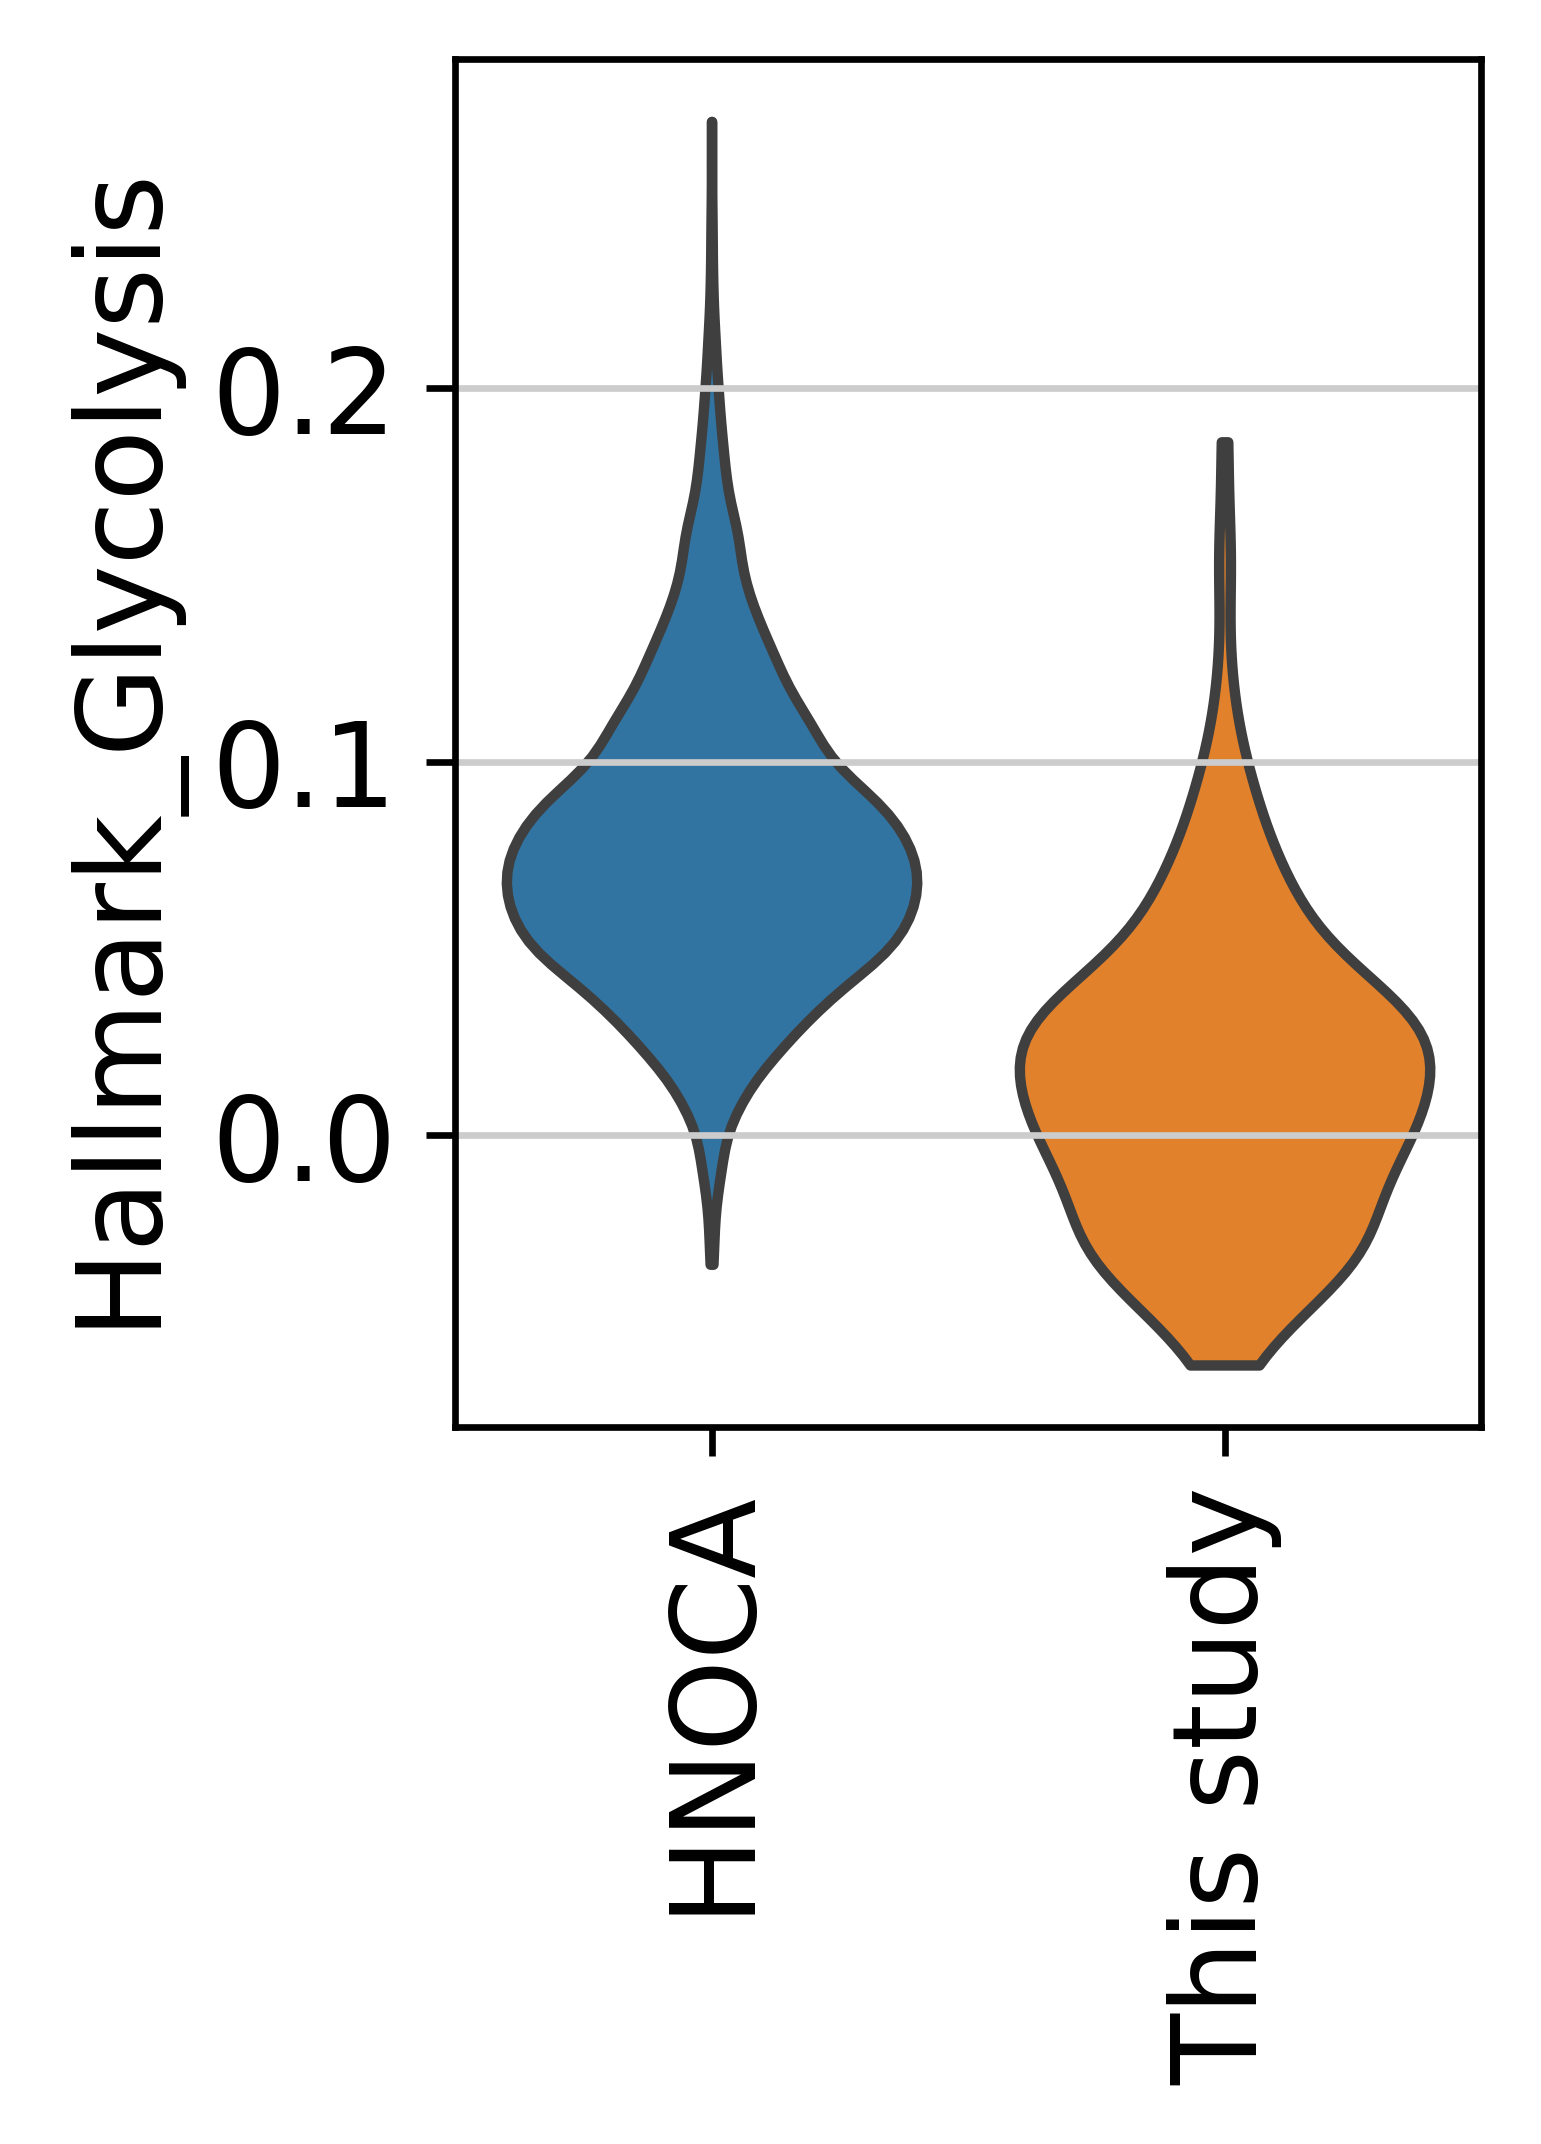

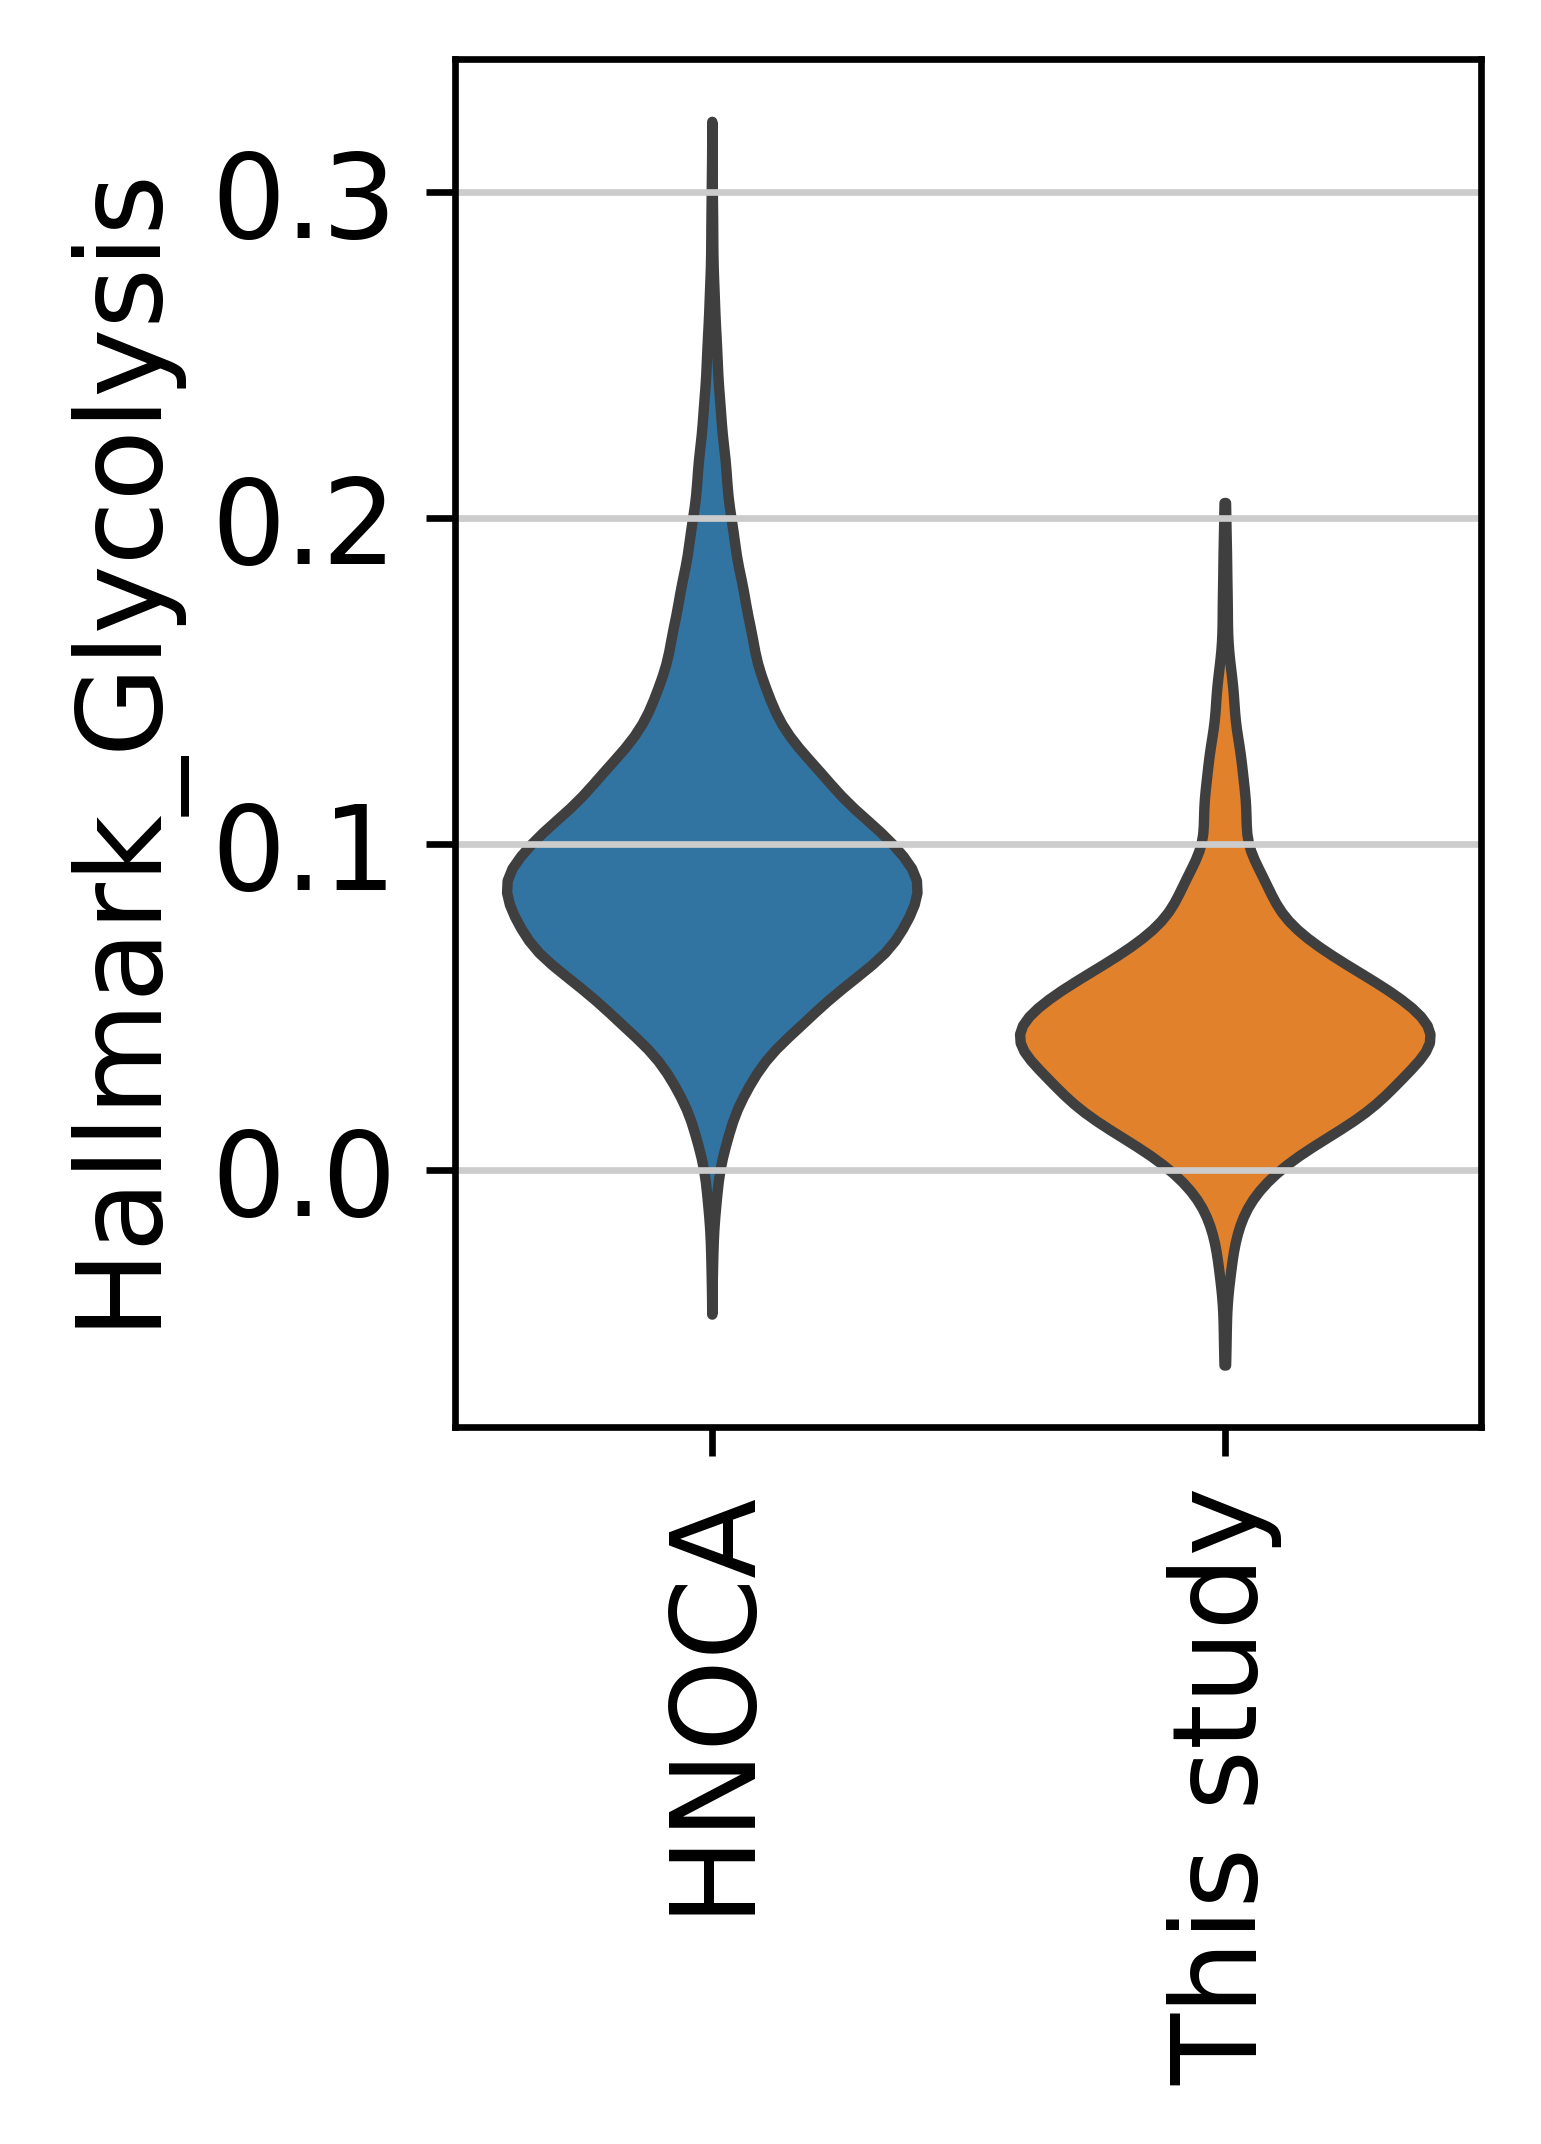

In [24]:
with plt.rc_context({"figure.figsize": (3,3), "figure.dpi": (300)}):
    sc.pl.violin(adata[(adata.obs['annot_level_1'].astype(str)=="OPC") | (adata.obs['final_annot_level_2'].astype(str)=='OPC')], keys='Hallmark_Glycolysis', groupby='source', log=False, rotation=90, stripplot=False, show=False)
    plt.savefig('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/figures/03d_transcriptomic_fidelity/Glycolysis_violin_opc.pdf', bbox_inches="tight")
    sc.pl.violin(adata[(adata.obs['annot_level_1'].astype(str)=="Glioblast") | (adata.obs['final_annot_level_2'].astype(str)=='Glioblast')], keys='Hallmark_Glycolysis', groupby='source', log=False, rotation=90, stripplot=False, show=False)
    plt.savefig('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/figures/03d_transcriptomic_fidelity/Glycolysis_violin_glioblast.pdf', bbox_inches="tight")

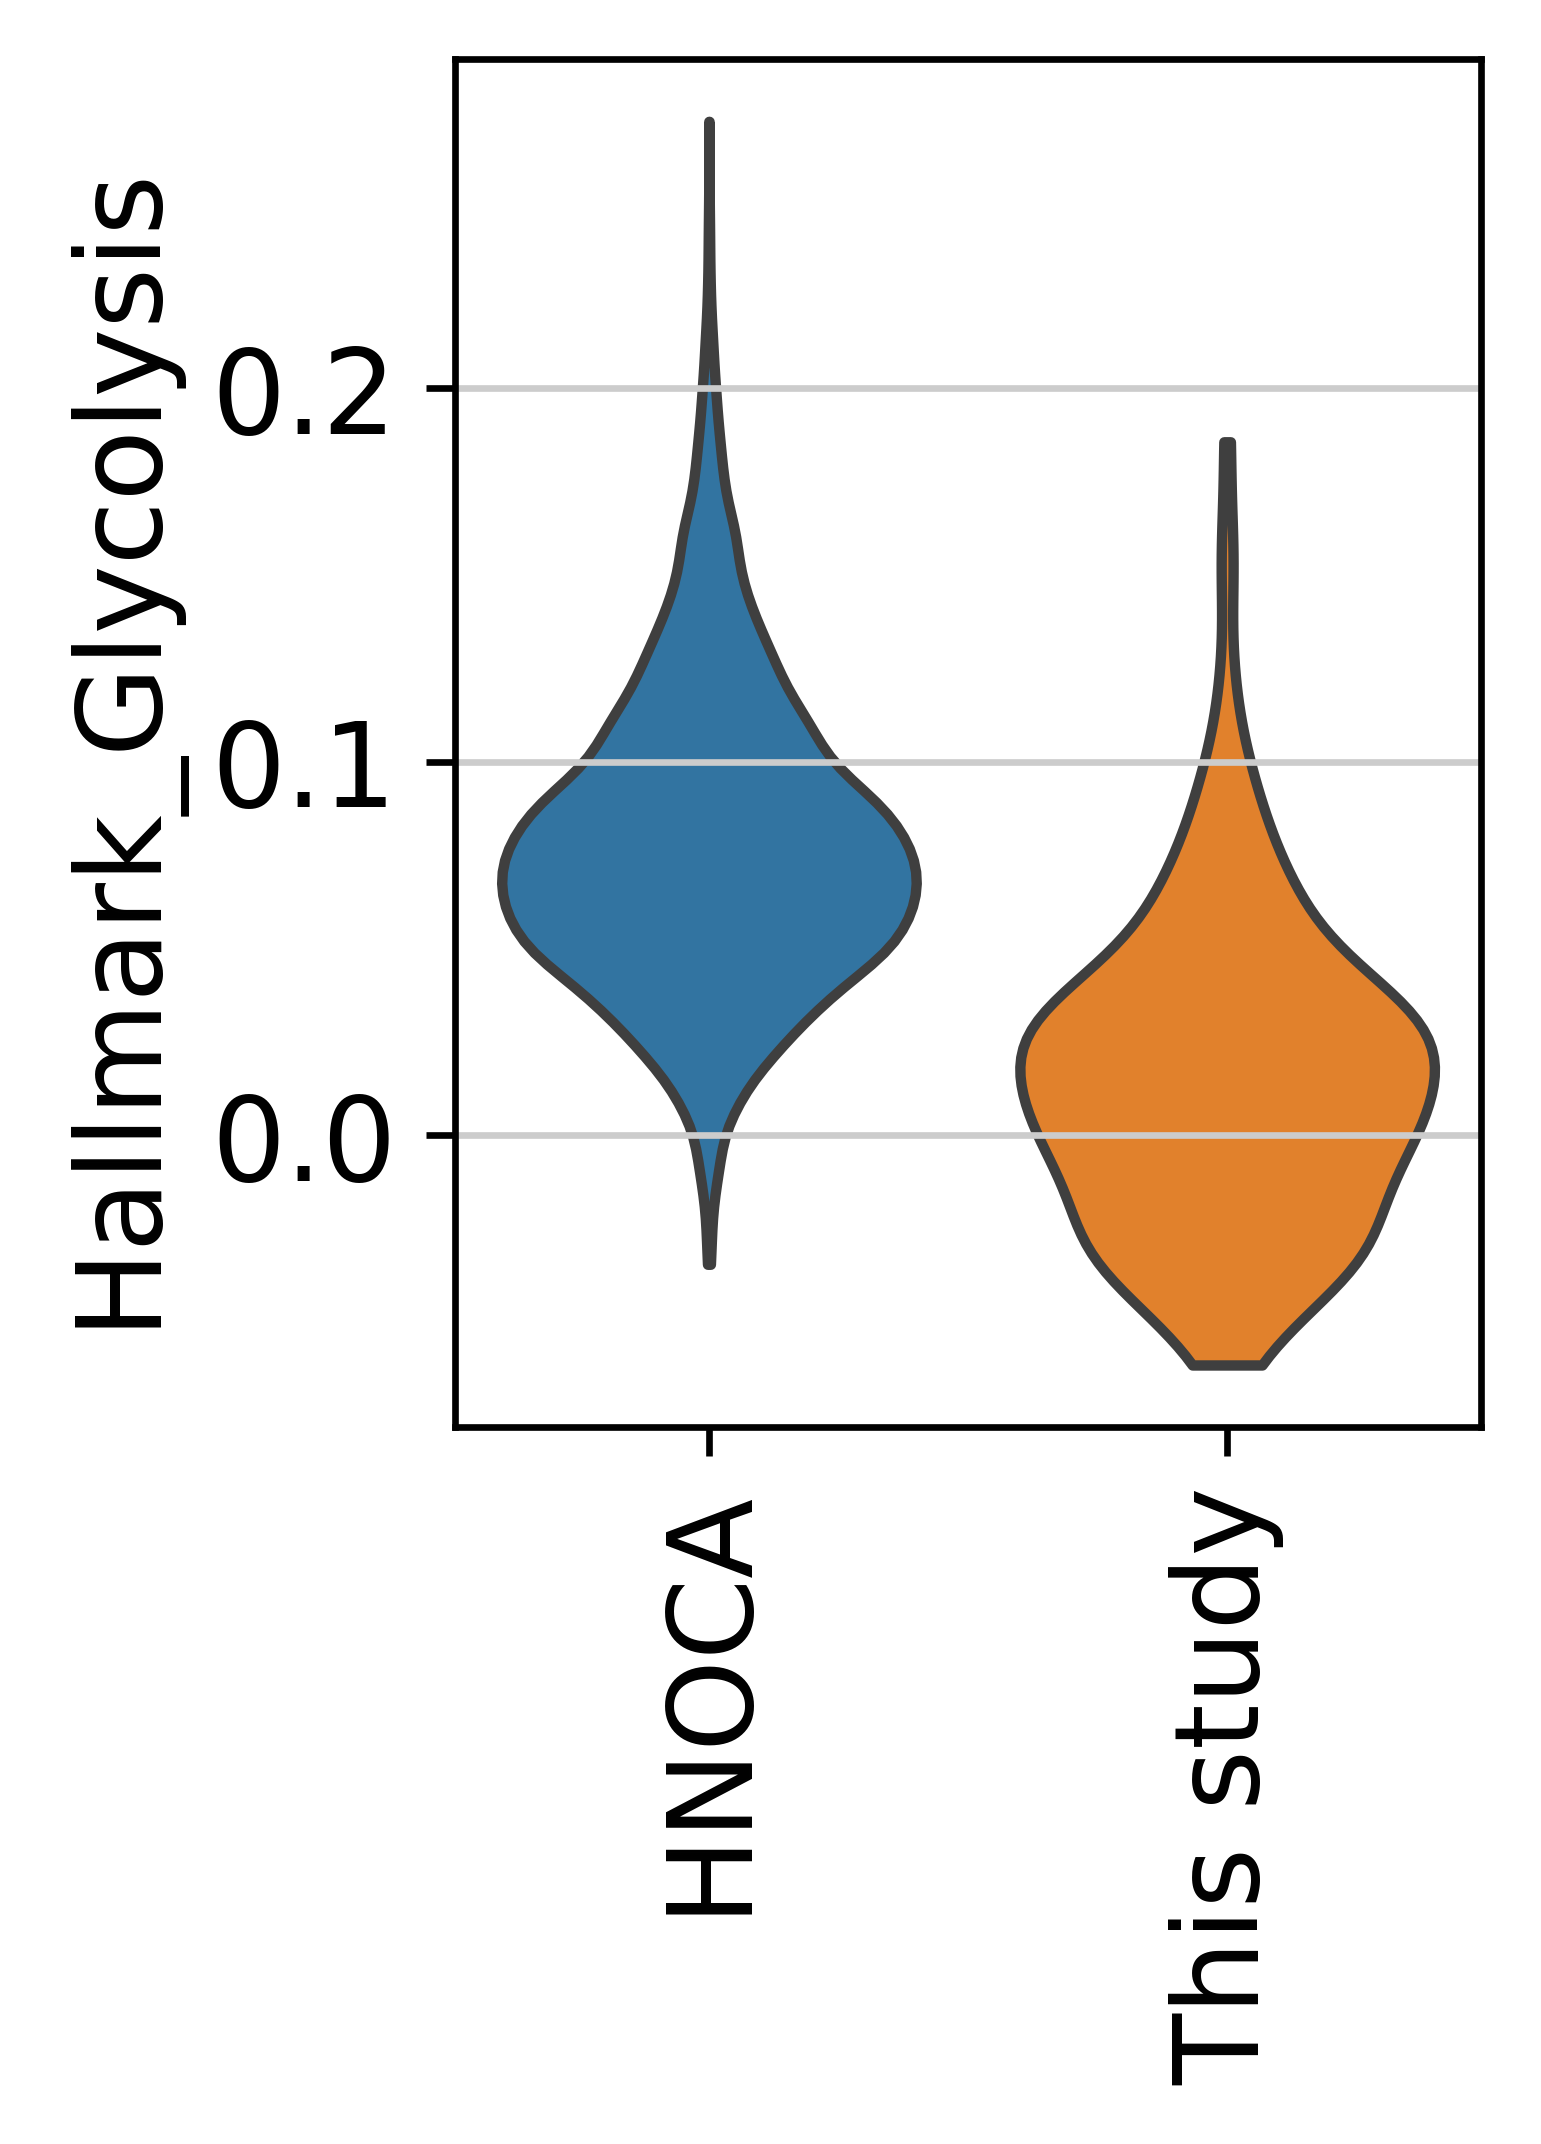

In [51]:
with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": 300}):
    # Step 1: Violin plot
    sc.pl.violin(
        opc_sub,
        keys='Hallmark_Glycolysis', 
        groupby='source', 
        order=['HNOCA', 'This study'],
        log=False, 
        rotation=90, 
        stripplot=False, 
        show=False
    )
    
    # Step 2: Compute mean glycolysis scores per replicate
    replicate_means = opc_sub.obs.groupby(['source', 'replication'])['Hallmark_Glycolysis'].mean().reset_index()

    # Extract group means
    group1_means = replicate_means.loc[replicate_means['source'] == 'HNOCA', 'Hallmark_Glycolysis'].values
    group2_means = replicate_means.loc[replicate_means['source'] == 'This study', 'Hallmark_Glycolysis'].values

    # Debugging: Check group data
    if group1_means.size == 0 or group2_means.size == 0:
        raise ValueError("One or both groups are empty. Check your 'source' or 'replication' column for consistency.")

    # Step 3: Perform permutation test
    obs_diff, p_value_perm = permutation_test(group1_means, group2_means)

    # Step 4: Annotate the plot
    # Determine significance level and corresponding asterisks
    significance = get_significance_asterisks(p_value_perm)

    # Find the y-position for the annotation
    y_max = max(group1_means.max(), group2_means.max())
    y_pos = y_max + 0.1 * (y_max - min(group1_means.min(), group2_means.min()))  # Adjust for spacing

    # Add line and asterisks for significance
    x_positions = [0, 1]  # Adjust based on your samples' positions
    plt.plot(x_positions, [y_pos, y_pos], color='black', linewidth=1.5)  # Line

    # Add the asterisks
    plt.text(
        x=0.5,  # Midpoint between groups
        y=y_pos + 0.02,  # Slightly above the line
        s=significance,
        ha='center',
        fontsize=12,
        color='black'
    )

    # Add the permutation-based p-value
    plt.text(
        x=0.5,  # Midpoint between groups
        y=y_pos + 0.08,  # Further above the asterisks
        s=f'p = {p_value_perm:.3e}',  # p-value in scientific notation
        ha='center',
        fontsize=10,
        color='black'
    )

    # Save the plot
    plt.savefig('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/figures/03d_transcriptomic_fidelity/Glycolysis_violin_opc_perm.pdf', bbox_inches="tight")

    plt.show()

In [46]:
opc_sub = adata[(adata.obs['annot_level_1'].astype(str)=="OPC") | (adata.obs['final_annot_level_2'].astype(str)=='OPC')]
glio_sub = adata[(adata.obs['annot_level_1'].astype(str)=="Glioblast") | (adata.obs['final_annot_level_2'].astype(str)=='Glioblast')]

In [42]:
adata.obs['replication'] = adata.obs.apply(
    lambda row: row['Day'] if row['publication'] == "This study" else row['publication'],
    axis=1
)
adata.obs['replication'].value_counts()

replication
Paulsen, 2022         301114
Uzquiano, 2022        263827
Bhaduri, 2020         223453
Bowles, 2021          202090
Velasco, 2019         156220
Fiorenzano, 2021      110026
Treutlein, 2023       109255
He, 2022               82121
Kanton, 2019           78491
Fleck, 2022            32278
Samarasinghe, 2021     27874
Huang, 2021            26693
Pellegrini, 2020       25033
Miura, 2020            19011
Andersen, 2020         16703
Trujillo, 2019         14903
Atamian, 2024          14285
Khan, 2020             13421
020                    13298
Yoon, 2019             11770
Birey, 2017            11306
Xiang, 2019            10568
Vertesy, 2022           8599
011                     8316
005                     7508
030                     6459
Qian, 2020              6381
060                     5992
014                     5479
120                     4710
090                     3565
Kelava, 2022            2758
Sawada, 2020            1441
Sloan, 2017              678
Ma

In [54]:
# Define a function for significance annotation
def get_significance_asterisks(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'  # Not significant

# Permutation test function
def permutation_test(group1, group2, n_permutations=10000):
    # Ensure valid inputs
    if len(group1) == 0 or len(group2) == 0:
        raise ValueError("One or both groups are empty. Cannot perform the permutation test.")
    
    # Remove any NaN values
    group1 = group1[np.isfinite(group1)]
    group2 = group2[np.isfinite(group2)]
    
    # Compute observed mean difference
    obs_diff = group1.mean() - group2.mean()
    
    # Combine all values and shuffle labels
    combined = np.concatenate([group1, group2])
    perm_diffs = []
    
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_group1 = combined[:len(group1)]
        perm_group2 = combined[len(group1):]
        perm_diffs.append(perm_group1.mean() - perm_group2.mean())
    
    # Calculate p-value
    perm_diffs = np.array(perm_diffs)
    p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))
    
    return obs_diff, p_value

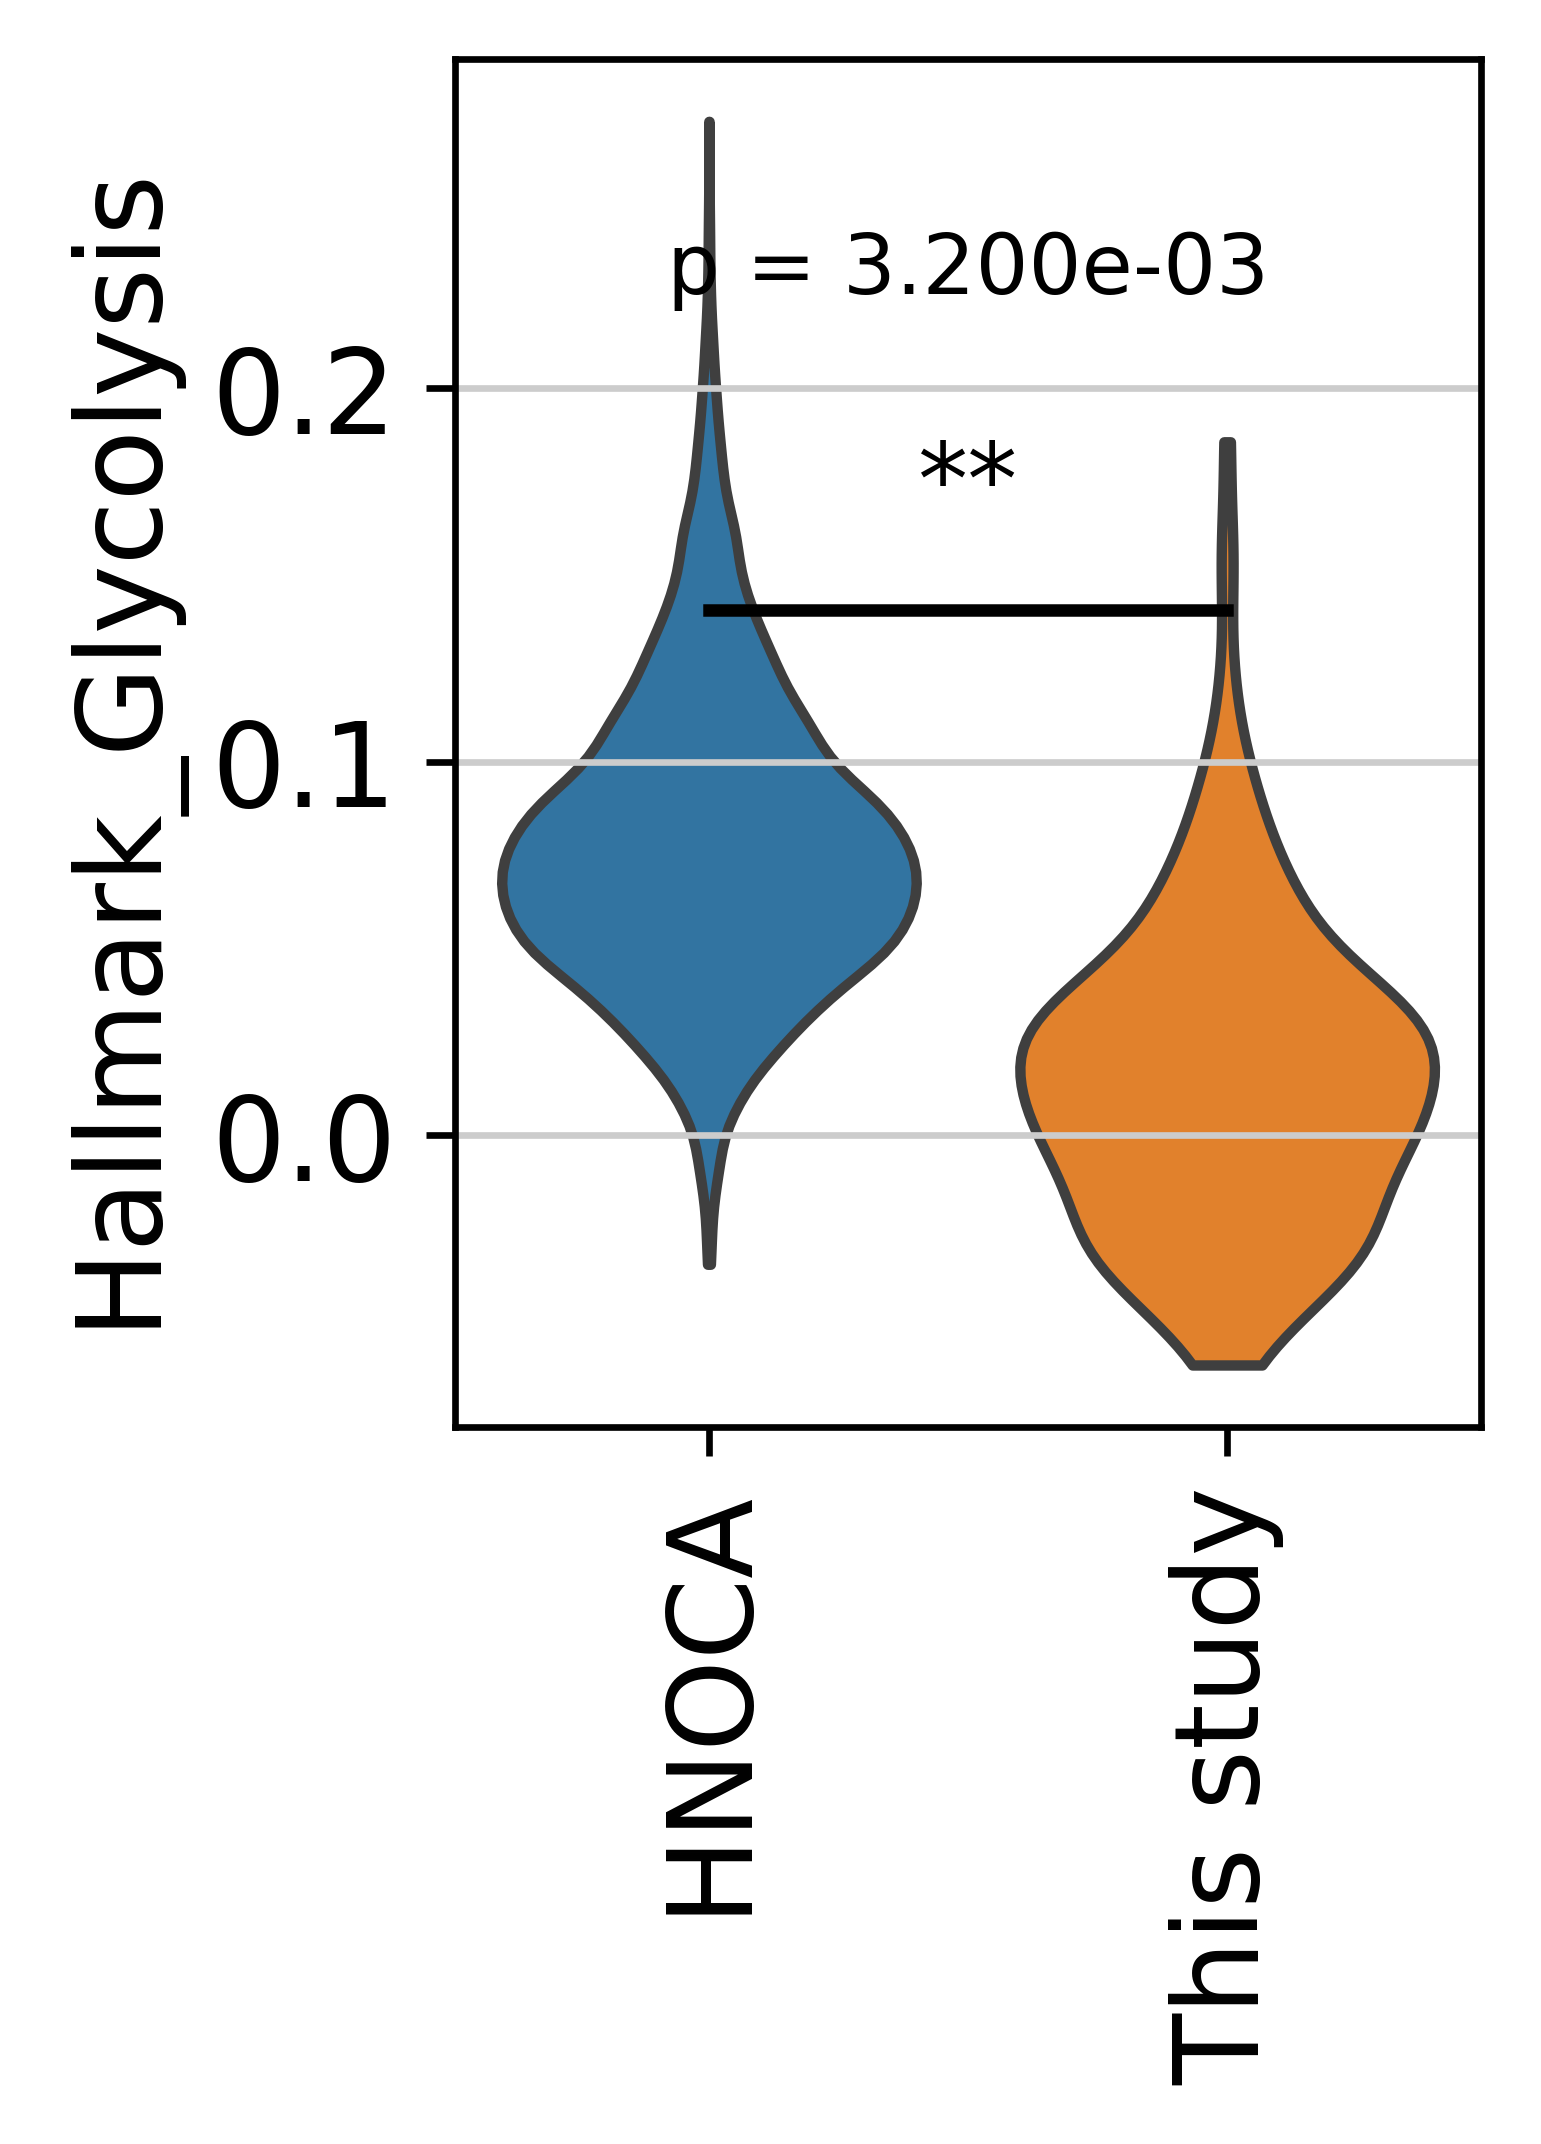

In [56]:
# Set up the plot context for consistent style
with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": 300}):
    # Step 1: Violin plot
    sc.pl.violin(
        opc_sub,
        keys='Hallmark_Glycolysis', 
        groupby='source', 
        order=['HNOCA', 'This study'],
        log=False, 
        rotation=90, 
        stripplot=False, 
        show=False
    )
    
    # Step 2: Compute mean glycolysis scores per replicate
    replicate_means = opc_sub.obs.groupby(['source', 'replication'])['Hallmark_Glycolysis'].mean().reset_index()

    # Extract group means
    group1_means = replicate_means.loc[replicate_means['source'] == 'HNOCA', 'Hallmark_Glycolysis'].values
    group2_means = replicate_means.loc[replicate_means['source'] == 'This study', 'Hallmark_Glycolysis'].values

    # Handle NaN or empty groups
    if len(group1_means) == 0 or len(group2_means) == 0:
        raise ValueError("One or both groups are empty. Check your 'source' or 'replication' column for consistency.")

    # Step 3: Perform permutation test
    try:
        obs_diff, p_value_perm = permutation_test(group1_means, group2_means)
    except ValueError as e:
        raise RuntimeError(f"Permutation test failed: {e}")

    # Step 4: Annotate the plot
    # Determine significance level and corresponding asterisks
    significance = get_significance_asterisks(p_value_perm)

    # Y-position for annotation
    y_max = max(np.nanmax(group1_means), np.nanmax(group2_means))
    y_min = min(np.nanmin(group1_means), np.nanmin(group2_means))
    y_pos = y_max + 0.1 * (y_max - y_min)  # Adjust for spacing

    # Plot the line and asterisks
    x_positions = [0, 1]  # Adjust based on your samples' positions
    plt.plot(x_positions, [y_pos, y_pos], color='black', linewidth=1.5)

    # Add asterisks
    plt.text(
        x=0.5,  # Midpoint between groups
        y=y_pos + 0.02,  # Slightly above the line
        s=significance,
        ha='center',
        va='bottom',  # Vertical alignment for better spacing
        fontsize=12,
        color='black'
    )

    # Add p-value
    plt.text(
        x=0.5,  # Midpoint between groups
        y=y_pos + 0.08,  # Further above the asterisks
        s=f'p = {p_value_perm:.3e}',  # p-value in scientific notation
        ha='center',
        va='bottom',  # Vertical alignment
        fontsize=10,
        color='black'
    )

    # Save the plot
    plt.savefig('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/figures/03d_transcriptomic_fidelity/Glycolysis_violin_opc_perm.pdf', bbox_inches="tight")

    plt.show()


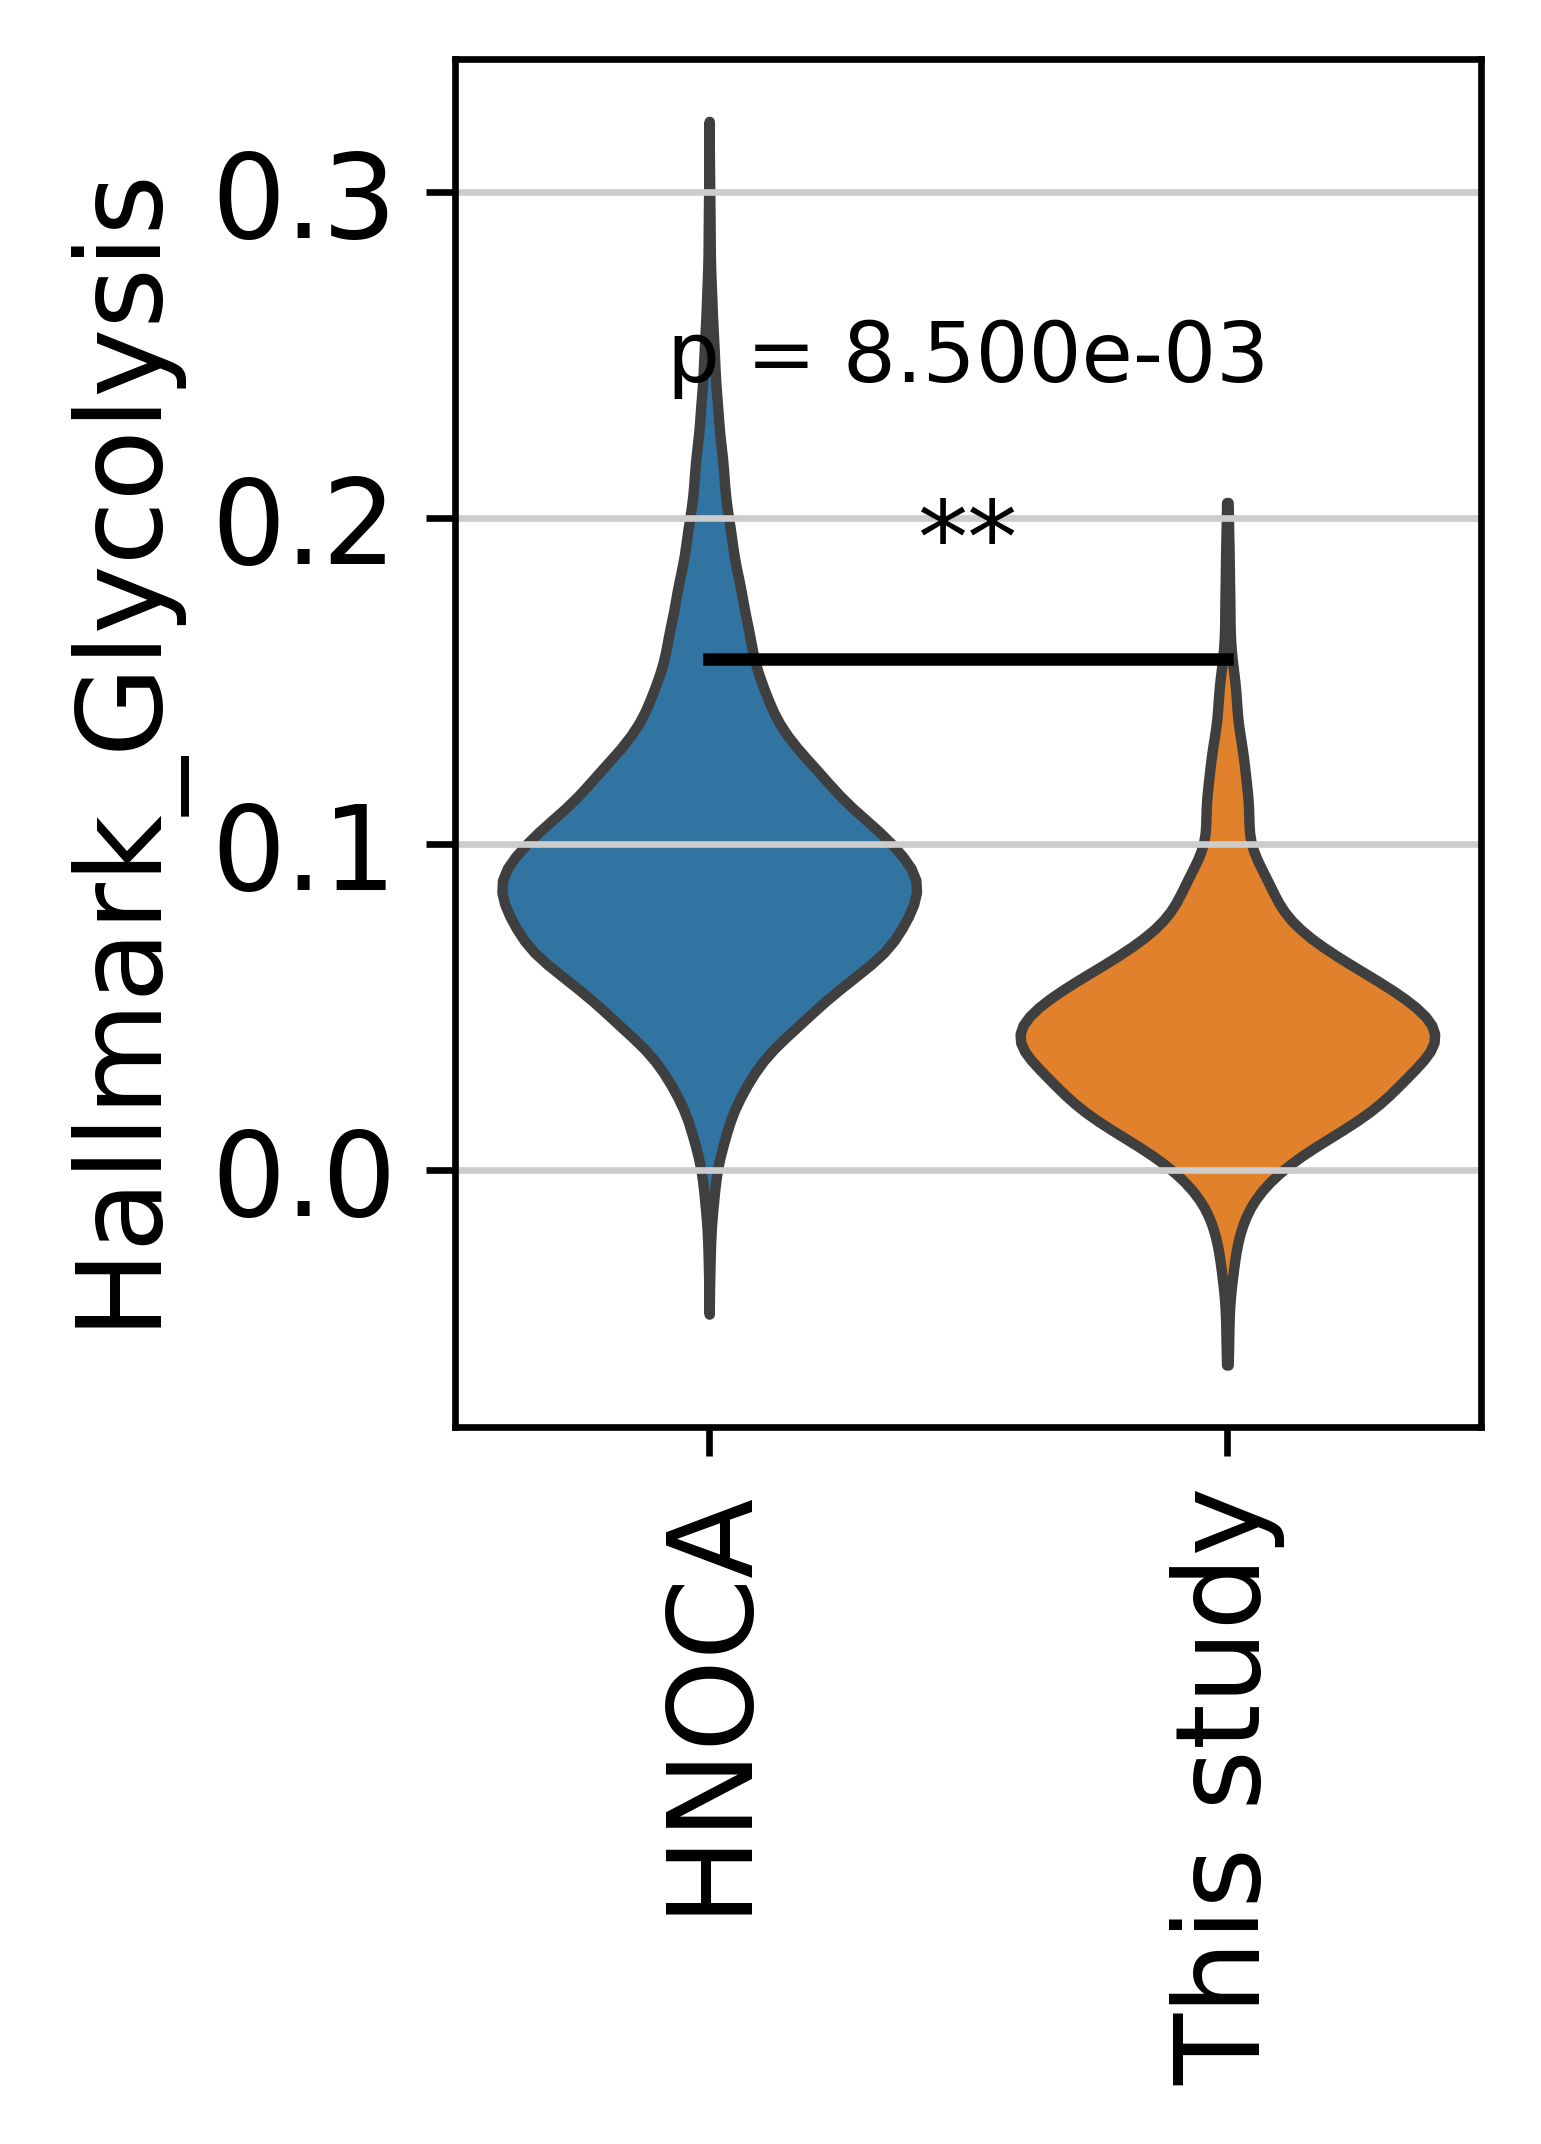

In [57]:
# Set up the plot context for consistent style
with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": 300}):
    # Step 1: Violin plot
    sc.pl.violin(
        glio_sub,
        keys='Hallmark_Glycolysis', 
        groupby='source', 
        order=['HNOCA', 'This study'],
        log=False, 
        rotation=90, 
        stripplot=False, 
        show=False
    )
    
    # Step 2: Compute mean glycolysis scores per replicate
    replicate_means = glio_sub.obs.groupby(['source', 'replication'])['Hallmark_Glycolysis'].mean().reset_index()

    # Extract group means
    group1_means = replicate_means.loc[replicate_means['source'] == 'HNOCA', 'Hallmark_Glycolysis'].values
    group2_means = replicate_means.loc[replicate_means['source'] == 'This study', 'Hallmark_Glycolysis'].values

    # Handle NaN or empty groups
    if len(group1_means) == 0 or len(group2_means) == 0:
        raise ValueError("One or both groups are empty. Check your 'source' or 'replication' column for consistency.")

    # Step 3: Perform permutation test
    try:
        obs_diff, p_value_perm = permutation_test(group1_means, group2_means)
    except ValueError as e:
        raise RuntimeError(f"Permutation test failed: {e}")

    # Step 4: Annotate the plot
    # Determine significance level and corresponding asterisks
    significance = get_significance_asterisks(p_value_perm)

    # Y-position for annotation
    y_max = max(np.nanmax(group1_means), np.nanmax(group2_means))
    y_min = min(np.nanmin(group1_means), np.nanmin(group2_means))
    y_pos = y_max + 0.1 * (y_max - y_min)  # Adjust for spacing

    # Plot the line and asterisks
    x_positions = [0, 1]  # Adjust based on your samples' positions
    plt.plot(x_positions, [y_pos, y_pos], color='black', linewidth=1.5)

    # Add asterisks
    plt.text(
        x=0.5,  # Midpoint between groups
        y=y_pos + 0.02,  # Slightly above the line
        s=significance,
        ha='center',
        va='bottom',  # Vertical alignment for better spacing
        fontsize=12,
        color='black'
    )

    # Add p-value
    plt.text(
        x=0.5,  # Midpoint between groups
        y=y_pos + 0.08,  # Further above the asterisks
        s=f'p = {p_value_perm:.3e}',  # p-value in scientific notation
        ha='center',
        va='bottom',  # Vertical alignment
        fontsize=10,
        color='black'
    )

    # Save the plot
    plt.savefig('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/figures/03d_transcriptomic_fidelity/Glycolysis_violin_glioblast_perm.pdf', bbox_inches="tight")

    plt.show()


# HNOCA DEGS

In [ ]:
query = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/BRO_RA1_exp023_annotated_integrated_final.h5ad')
hnoca = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/HNOCA/hnoca_cleanedmeta.h5ad')

In [21]:
hvg_genes = pd.read_csv('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/HNOCA/models/published_scpoli/scpoli_model_params/var_names.csv')
hvg_genes

TNMD
0                 CFH
1                CD99
2               SNX11
3            TMEM176A
4             CYP26B1
...               ...
2994  ENSG00000288105
2995  ENSG00000288253
2996  ENSG00000288321
2997        LINC01949
2998     C8orf44-SGK3

[2999 rows x 1 columns]

# DEG glial lineages

In [46]:
query = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/BRO_RA1_exp023_annotated_integrated_final.h5ad')
atlas = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/Braun_HDBCA_HNOCA-harmonized.h5ad')
hnoca = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/HNOCA/hnoca_cleanedmeta.h5ad')

print(query)
print("")
print(atlas)
print("")
print(hnoca)

AnnData object with n_obs × n_vars = 55327 × 23409
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_res_1', 'leiden_res_2', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'leiden_diffmap_res_4', 'snapseed_level_1', 'snapseed_level_2', 'snapseed_level_3', 'snapseed_level_4', 'snapseed_level_5', 'leiden_res_0.5', 'hnoca_level_1', 'hnoca_level_1_score', 'hnoca_level_1_logscore', 'hnoca_level_2', 'hnoca_level_2_score', 'hnoca_level_2_logscore', 'hnoca_level_3', 'hnoca_level_3_score', 'hnoca_level_3_logscore', 'hnoca_level_4', 'hnoca_level_4_score', 'hnoca_level_4_logscore', 'hdbca

In [47]:
joint_genes = sorted(list(set(query.var.index) & set(hnoca.var.index) & set(atlas.var.index)))

In [48]:
xy_genes = pd.read_csv('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/assets/xy_genes_biomart.tsv', delimiter='\t')

### Subset, harmonize and merge different OPC datasets

In [150]:
query = query[:,joint_genes]
q_opc = query[query.obs['final_annot_level_1']=="OPC"].copy()
q_opc.X = q_opc.layers['counts'].copy()
q_opc.var_names_make_unique()
q_opc.obs_names_make_unique()
sc.pp.normalize_total(q_opc, target_sum=1e6)
sc.pp.log1p(q_opc)
sc.pp.filter_cells(q_opc, min_genes=200)
q_opc

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 563 × 21543
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_res_1', 'leiden_res_2', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'leiden_diffmap_res_4', 'snapseed_level_1', 'snapseed_level_2', 'snapseed_level_3', 'snapseed_level_4', 'snapseed_level_5', 'leiden_res_0.5', 'hnoca_level_1', 'hnoca_level_1_score', 'hnoca_level_1_logscore', 'hnoca_level_2', 'hnoca_level_2_score', 'hnoca_level_2_logscore', 'hnoca_level_3', 'hnoca_level_3_score', 'hnoca_level_3_logscore', 'hnoca_level_4', 'hnoca_level_4_score', 'hnoca_level_4_logscore', 'hdbca_l

In [151]:
atlas = atlas[:,joint_genes]
a_opc = atlas[atlas.obs['CellClass']=='Oligo'].copy()
a_opc.X = a_opc.layers['counts'].copy()
a_opc.var_names_make_unique()
a_opc.obs_names_make_unique()
sc.pp.normalize_total(a_opc, target_sum=1e6)
sc.pp.log1p(a_opc)
sc.pp.filter_cells(a_opc, min_genes=200)
a_opc

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 6190 × 21543
    obs: 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'dissection', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'GeneTotalUMIs', 'Start', 'Gene'
    uns: 'batch_condition', 'log1p', 'neighbors', 'pca', 'title', 'umap'
    obsm: 'Factors', 'X_Embedding', 'X_pca', 'X_umap'
    varm: 'Loadings', 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [152]:
hnoca = hnoca[:,joint_genes]
h_opc = hnoca[hnoca.obs['annot_level_1']=='OPC'].copy()
h_opc.X = h_opc.layers['counts_lengthnorm'].copy()
h_opc.layers['counts'] = h_opc.layers['counts_lengthnorm'].copy()
h_opc.var_names_make_unique()
h_opc.obs_names_make_unique()
sc.pp.normalize_total(h_opc, target_sum=1e6)
sc.pp.log1p(h_opc)
sc.pp.filter_cells(h_opc, min_genes=200)
h_opc

normalizing counts per cell
    finished (0:00:01)


AnnData object with n_obs × n_vars = 8325 × 21543
    obs: 'assay_differentiation', 'assay_sc', 'assay_sc_original', 'assay_type_differentiation', 'bio_sample', 'cell_line', 'cell_line_original', 'cell_type', 'cell_type_original', 'development_stage', 'disease', 'disease_original', 'ethnicity', 'ethnicity_original', 'gm', 'id', 'individual', 'organ', 'organ_original', 'organism', 'organism_original', 'sample_source', 'sex', 'sex_original', 'state_exact', 'suspension_type', 'suspension_type_original', 'tech_sample', 'treatment', 'obs_names_original', 'organoid_age_days', 'publication', 'doi', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'annot_level_1', 'annot_level_2', 'annot_level_3_rev2', 'annot_level_4_rev2', 'annot_region_rev2', 'annot_ntt_rev2', 'Hallmark_Glycolysis', 'n_genes'
    var: 'ensembl', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts

In [153]:
q_opc.obs['dataset'] = "Query"
a_opc.obs['dataset'] = 'HDBCA'
h_opc.obs['dataset'] = "HNOCA"
q_opc.obs['age'] = q_opc.obs['Day'].astype(np.float32)
a_opc.obs['age'] = a_opc.obs['Age'].astype(np.float32) * 7
h_opc.obs['age'] = h_opc.obs['organoid_age_days'].astype(np.float32)
opc = q_opc.concatenate([a_opc, h_opc])
#opc.layers['counts'] = np.concatenate([q_opc.layers['counts'],a_opc.layers['counts'], h_opc.layers['counts']])
opc

AnnData object with n_obs × n_vars = 15078 × 21543
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_res_1', 'leiden_res_2', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'leiden_diffmap_res_4', 'snapseed_level_1', 'snapseed_level_2', 'snapseed_level_3', 'snapseed_level_4', 'snapseed_level_5', 'leiden_res_0.5', 'hnoca_level_1', 'hnoca_level_1_score', 'hnoca_level_1_logscore', 'hnoca_level_2', 'hnoca_level_2_score', 'hnoca_level_2_logscore', 'hnoca_level_3', 'hnoca_level_3_score', 'hnoca_level_3_logscore', 'hnoca_level_4', 'hnoca_level_4_score', 'hnoca_level_4_logscore', 'hdbca

In [154]:
# Remove any genes located on the X and Y Chromosome or expressed in less than 1% of organoids cells
non_xy_genes = [gene for gene in opc.var.index if gene not in xy_genes['hgnc_symbol'].values]

n_cells = (opc.X > 0).sum(axis=0)
one_perc_genes = opc.var.iloc[np.where(n_cells.A.ravel() > round(0.01*opc.n_obs))[0]].index.tolist()

cleaned_features = sorted(list(set(one_perc_genes) & set(non_xy_genes)))

In [155]:
len(cleaned_features)

13022

In [156]:
opc = opc[:,cleaned_features]

In [73]:
opc.X = opc.layers['counts'].copy()
sc.pp.normalize_total(opc, target_sum=1e6)
sc.pp.log1p(opc)

normalizing counts per cell
    finished (0:00:00)


computing PCA
    with n_comps=50
    finished (0:00:44)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:10)


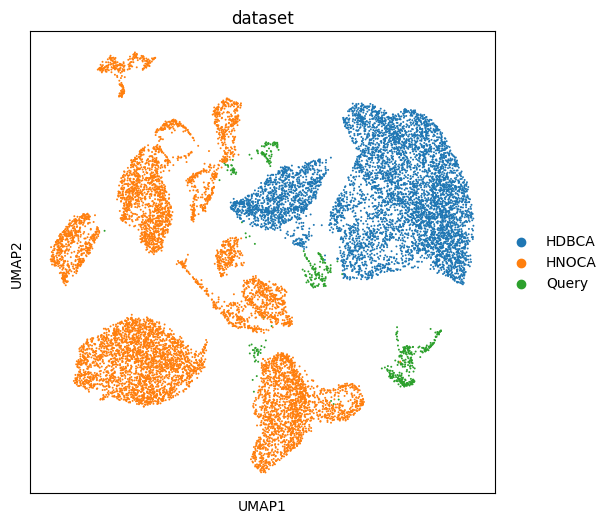

In [74]:
sc.pp.pca(opc, n_comps=50)
sc.pp.neighbors(opc, n_pcs=30)
sc.tl.umap(opc)
sc.pl.umap(opc, color=["dataset"])

Quick correlation check

In [75]:
mean_expr_query = np.mean(q_opc[:,cleaned_features].X, axis=0)
mean_expr_atlas = np.mean(a_opc[:,cleaned_features].X, axis=0)
mean_expr_hnoca = np.mean(h_opc[:,cleaned_features].X, axis=0)

In [76]:
correlation_atlas = np.corrcoef(mean_expr_query, mean_expr_atlas)[0, 1]
correlation_hnoca = np.corrcoef(mean_expr_query, mean_expr_hnoca)[0, 1]
correlation_hnoca_atlas = np.corrcoef(mean_expr_atlas, mean_expr_hnoca)[0, 1]
print('correlation to HDBCA: ', correlation_atlas)
print('correlation to HNOCA: ', correlation_hnoca)
print('correlation to HNOCA to HDBCA: ', correlation_hnoca_atlas)

correlation to HDBCA:  0.4435287018507277
correlation to HNOCA:  0.7384554294293032
correlation to HNOCA to HDBCA:  0.4676353850428209


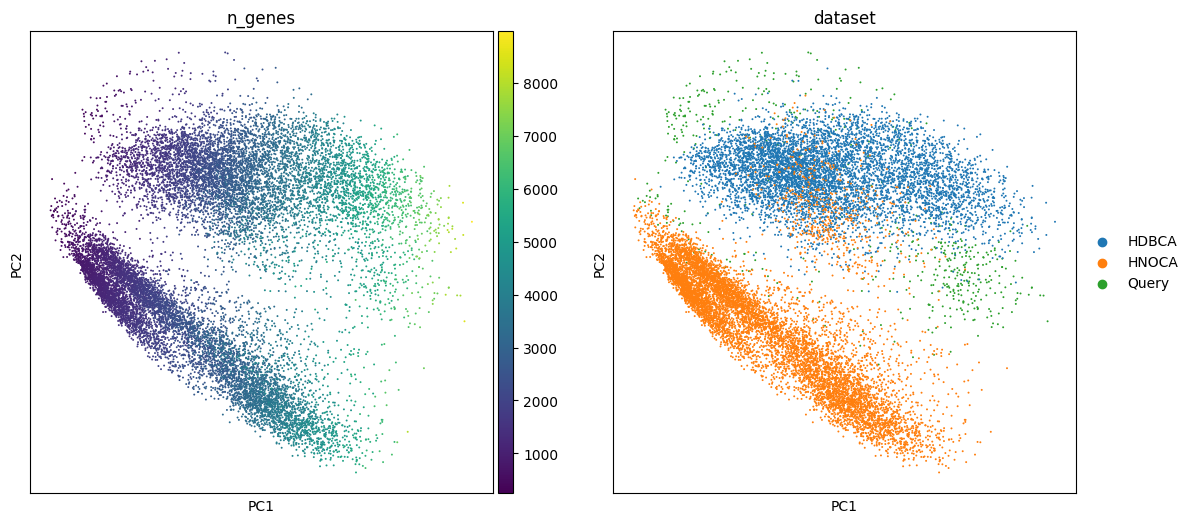

In [77]:
sc.pl.pca(opc, color=['n_genes','dataset'])

In [35]:
opc.obs['n_genes'] = opc.obs['n_genes'].astype(int)

### Pseudobulk and edgeR 

In [157]:
opc.layers['log1p_norm']= opc.X.copy()
opc.X = opc.layers['counts'].copy()
opc.obs['n_genes'] = (opc.X>0).sum(axis=1).A.ravel()

/scratch/28768602/ipykernel_2324407/1213407503.py:1: ImplicitModificationWarning: Setting element `.layers['log1p_norm']` of view, initializing view as actual.
  opc.layers['log1p_norm']= opc.X.copy()


processing Query
matching cell counts to 676
creating 3 pseudo-replicates
processing HDBCA
matching cell counts to 676
creating 3 pseudo-replicates
processing HNOCA
matching cell counts to 676
creating 3 pseudo-replicates
normalizing counts per cell
    finished (0:00:00)
creating pseudobulk using dataset as sample_col
and sum as mode


dataset batch_rep batch replicate  psbulk_n_cells  \
HDBCA_HDBCA_0   HDBCA   HDBCA_0     1         0           226.0   
HDBCA_HDBCA_1   HDBCA   HDBCA_1     1         1           225.0   
HDBCA_HDBCA_2   HDBCA   HDBCA_2     1         2           225.0   
HNOCA_HNOCA_0   HNOCA   HNOCA_0     2         0           226.0   
HNOCA_HNOCA_1   HNOCA   HNOCA_1     2         1           225.0   
HNOCA_HNOCA_2   HNOCA   HNOCA_2     2         2           225.0   
Query_Query_0   Query   Query_0     0         0           188.0   
Query_Query_1   Query   Query_1     0         1           188.0   
Query_Query_2   Query   Query_2     0         2           187.0   

               psbulk_counts  log_psbulk_counts  n_genes_median  n_genes_std  
HDBCA_HDBCA_0      1589048.0          14.278646          2424.5  1189.571404  
HDBCA_HDBCA_1      1800163.0          14.403388          2605.0  1312.034034  
HDBCA_HDBCA_2      1470429.0          14.201065          2444.0  1084.357528  
HNOCA_HNOCA_0      3072257.0          14.937923          1849.0  1123.153397  
HNOCA_HNOCA_1      3944105.0          15.187733          2465.0  1187.935510  
HNOCA_HNOCA_2      5084048.0          15.441618          2318.0  1192.383568  
Query_Query_0      2042060.0          14.529470          3388.0  2094.236376  
Query_Query_1      1904045.0          14.459491          3353.5  2027.973935  
Query_Query_2      2031443.0          14.524257          3630.0  2111.559192

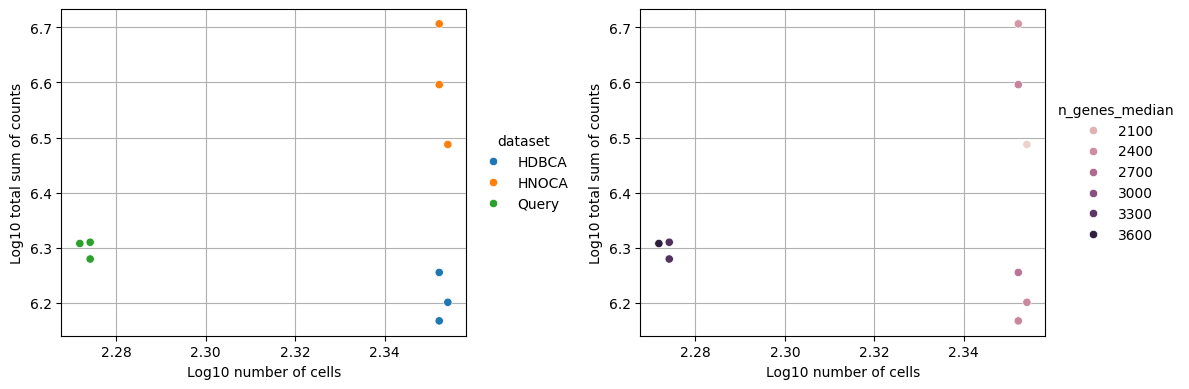

In [158]:
pdata = create_pseudobulk(opc, batch_column='dataset', replicates=3, matched=True, mode='sum')
pdata.obs

In [159]:
pdata.obs['replicate'] = pdata.obs['replicate'].astype(str)
pdata.write('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/03_transcriptomic_correlation/merged_opc_pseudobulk.h5ad')

In [11]:
pdata = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/03_transcriptomic_correlation/merged_opc_pseudobulk.h5ad')

In [36]:
pdata.obs

dataset batch_rep batch  replicate  psbulk_n_cells  \
HDBCA_HDBCA_0   HDBCA   HDBCA_0     1          1           226.0   
HDBCA_HDBCA_1   HDBCA   HDBCA_1     1          2           225.0   
HDBCA_HDBCA_2   HDBCA   HDBCA_2     1          3           225.0   
HNOCA_HNOCA_0   HNOCA   HNOCA_0     2          1           226.0   
HNOCA_HNOCA_1   HNOCA   HNOCA_1     2          2           225.0   
HNOCA_HNOCA_2   HNOCA   HNOCA_2     2          3           225.0   
Query_Query_0   Query   Query_0     0          1           188.0   
Query_Query_1   Query   Query_1     0          2           188.0   
Query_Query_2   Query   Query_2     0          3           187.0   

               psbulk_counts  log_psbulk_counts  n_genes_median  n_genes_std  
HDBCA_HDBCA_0      1589048.0          14.278646          2424.5  1189.571404  
HDBCA_HDBCA_1      1800163.0          14.403388          2605.0  1312.034034  
HDBCA_HDBCA_2      1470429.0          14.201065          2444.0  1084.357528  
HNOCA_HNOCA_0      3072257.0          14.937923          1849.0  1123.153397  
HNOCA_HNOCA_1      3944105.0          15.187733          2465.0  1187.935510  
HNOCA_HNOCA_2      5084048.0          15.441618          2318.0  1192.383568  
Query_Query_0      2042060.0          14.529470          3388.0  2094.236376  
Query_Query_1      1904045.0          14.459491          3353.5  2027.973935  
Query_Query_2      2031443.0          14.524257          3630.0  2111.559192

In [ ]:
psbulk_data = pdata.layers['psbulk_props']  # Assuming pseudobulk proportions
gene_names = pdata.var_names
datasets = pdata.obs['dataset']
replicates = pdata.obs['replicate']

In [40]:
# Initialize a list to store correlation results
correlation_results = []

# Loop through each model dataset
for dataset in pdata.obs['dataset'].unique():
    if dataset == "HDBCA":
        hdbca_data = pdata[pdata.obs['dataset']=="HDBCA"].X.mean(axis=0) 
        continue
    print(dataset)
    
    model_data = pdata[pdata.obs['dataset']== dataset]

    # Compute correlations for each replicate in the model
    for replicate in pdata.obs['replicate'][pdata.obs['dataset'] == dataset]:
        print(replicate)
        replicate_data = model_data[model_data.obs['replicate'] == replicate].X.mean(axis=0)
        correlation = np.corrcoef(replicate_data, hdbca_data)[0, 1]  # Compute Pearson correlation
        # Store the result
        correlation_results.append({'Dataset': dataset, 'Replicate': replicate, 'Correlation': correlation})

# Convert to a DataFrame for visualization
correlation_opc = pd.DataFrame(correlation_results)

HNOCA
1
2
3
Query
1
2
3


In [42]:
correlation_opc['sample'] = "OPC"
correlation_opc

Dataset  Replicate  Correlation sample
0   HNOCA          1     0.856714    OPC
1   HNOCA          2     0.826288    OPC
2   HNOCA          3     0.807568    OPC
3   Query          1     0.912069    OPC
4   Query          2     0.913385    OPC
5   Query          3     0.909935    OPC

In [12]:
pdata.obs['replicate'] = pdata.obs['replicate'].astype(int)+1

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

covariates = pdata.obs[["psbulk_n_cells", "psbulk_counts", "n_genes_median", "n_genes_std", 'log_psbulk_counts']]
correlation_matrix = covariates.corr()
print(correlation_matrix)  # Check pairwise correlations

vif = pd.DataFrame()
vif["features"] = covariates.columns
vif["VIF"] = [variance_inflation_factor(covariates.values, i) for i in range(covariates.shape[1])]
print(vif)

                   psbulk_n_cells  psbulk_counts  n_genes_median  n_genes_std  \
psbulk_n_cells           1.000000       0.331635       -0.935101    -0.990469   
psbulk_counts            0.331635       1.000000       -0.404179    -0.331154   
n_genes_median          -0.935101      -0.404179        1.000000     0.948831   
n_genes_std             -0.990469      -0.331154        0.948831     1.000000   
log_psbulk_counts        0.272824       0.988168       -0.372717    -0.269978   

                   log_psbulk_counts  
psbulk_n_cells              0.272824  
psbulk_counts               0.988168  
n_genes_median             -0.372717  
n_genes_std                -0.269978  
log_psbulk_counts           1.000000  
            features           VIF
0     psbulk_n_cells   7888.669138
1      psbulk_counts     66.361403
2     n_genes_median    306.291116
3        n_genes_std   1129.661945
4  log_psbulk_counts  14285.718626


In [14]:
r_edger_fit(pdata)

[1] "(Intercept)"  "datasetHNOCA" "datasetQuery"


array(['success'], dtype='<U7')

Testing coefficient: datasetQuery
[1] "datasetQuery"


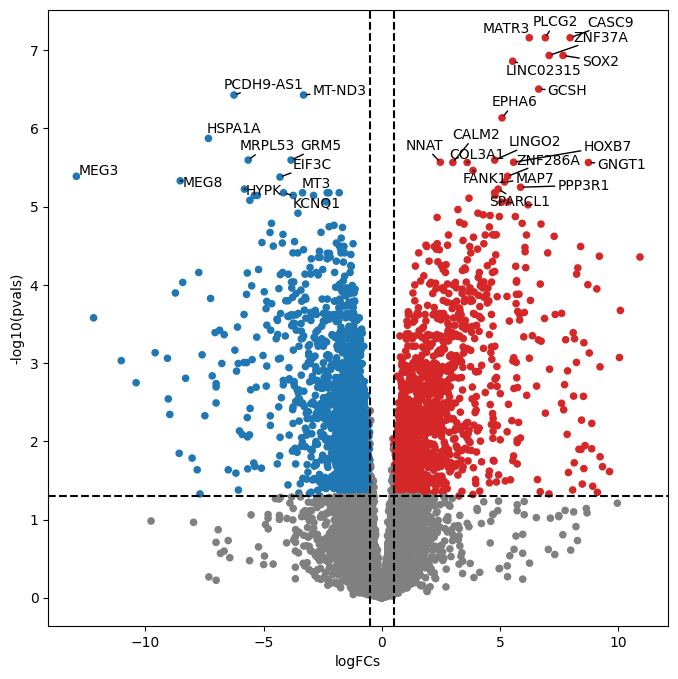

Testing coefficient: datasetHNOCA
[1] "datasetHNOCA"


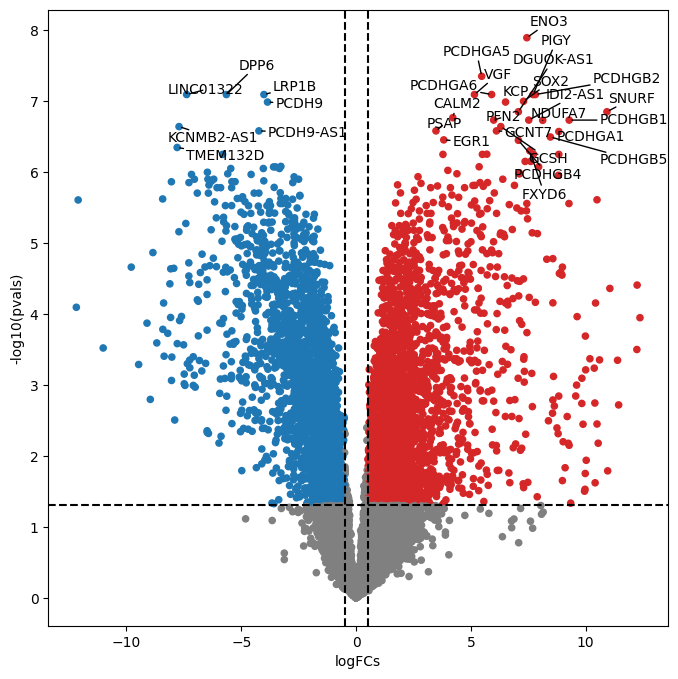

Testing contrast: datasetQuery - datasetHNOCA
[1] "datasetQuery - datasetHNOCA"


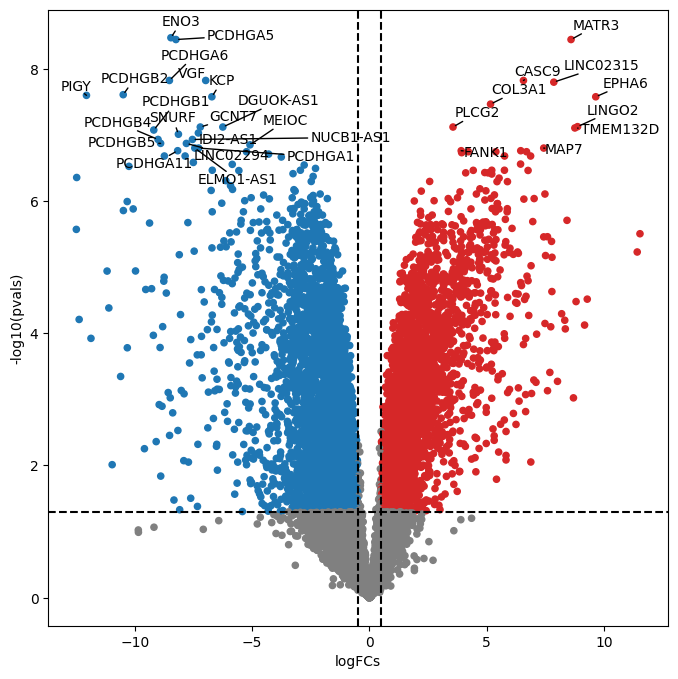

In [15]:
deg_q = edger_test(coef='datasetQuery', plot=True).sort_values("qval")
deg_h = edger_test(coef='datasetHNOCA', plot=True).sort_values("qval")
deg_hq = edger_test(contrast="datasetQuery - datasetHNOCA", plot=True).sort_values('qval')

### Clean results

In [16]:
results = {'HDBCA_Query':deg_q,
    "HDBCA_HNOCA":deg_h,
    "Query_HNOCA":deg_hq,}

In [17]:
results_cleaned, results_up, results_down = get_sig_results(results, qval_thres=0.05, lfc_abs_thres=0.5)

In [18]:
with pd.ExcelWriter(f"/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/03_transcriptomic_correlation/degs/OPC.xlsx", engine='xlsxwriter') as writer:
    for i in results_cleaned:
        results_cleaned[i].to_excel(writer, sheet_name=i)

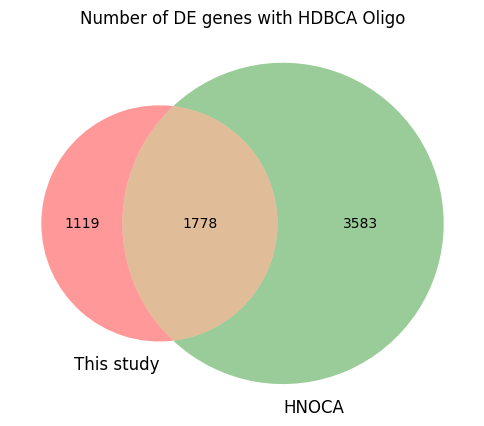

In [19]:
venn2((set(results_cleaned["HDBCA_Query"].index), set(results_cleaned['HDBCA_HNOCA'].index)), set_labels=("This study","HNOCA"))
plt.title("Number of DE genes with HDBCA Oligo")
plt.savefig('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/figures/03d_transcriptomic_fidelity/Venn_OPC.pdf', bbox_inches="tight")
plt.show()

In [172]:
# number of genes with aligned direction out of the shared DEGS
shared_degs = list(set(results_cleaned["HDBCA_Query"].index) & set(results_cleaned["HDBCA_HNOCA"].index))
shared_direction = np.sign(results_cleaned["HDBCA_Query"].loc[shared_degs, "log2fc"]) == np.sign(results_cleaned["HDBCA_HNOCA"].loc[shared_degs, "log2fc"])
shared_direction.value_counts()

log2fc
True     1161
False     617
Name: count, dtype: int64

In [173]:
len(pdata.var)-1119-3583-1178

7142

In [174]:
#odds ratio and contingency table for the overlap
contingency_table = [
    [7142, 3583],
    [1119, 1178]
]
odds_ratio, p_value = scipy.stats.fisher_exact(contingency_table)
odds_ratio, p_value

(2.0983998262074133, 7.417331731746562e-57)

In [175]:
shared_aligned_degs, unique_degs = get_deg_overlap(results_cleaned, comparisons=results_cleaned.keys())

In [176]:
results_cleaned_unique, results_up, results_down = get_sig_results(unique_degs, qval_thres=0.05, lfc_abs_thres=0.5)

HDBCA_Query


900 de genes


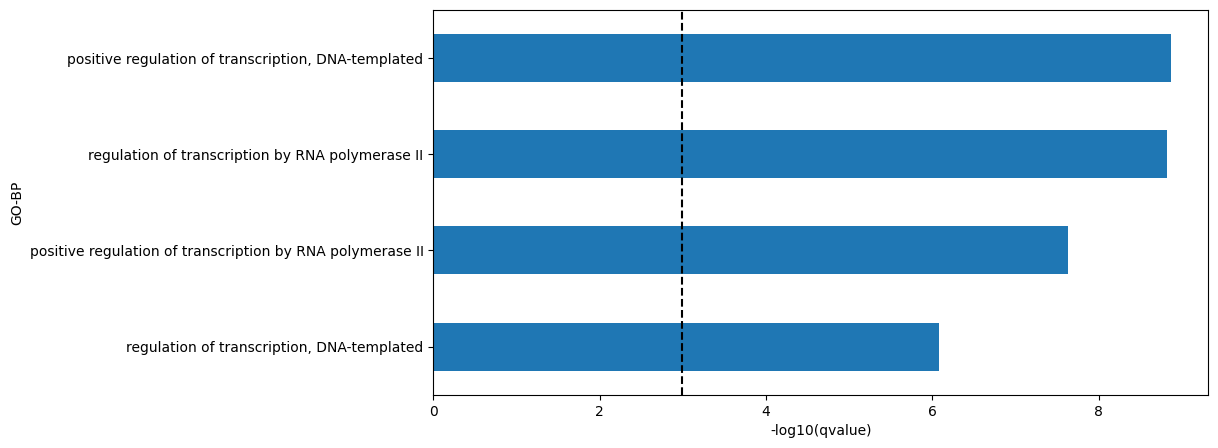

HDBCA_HNOCA
2156 de genes


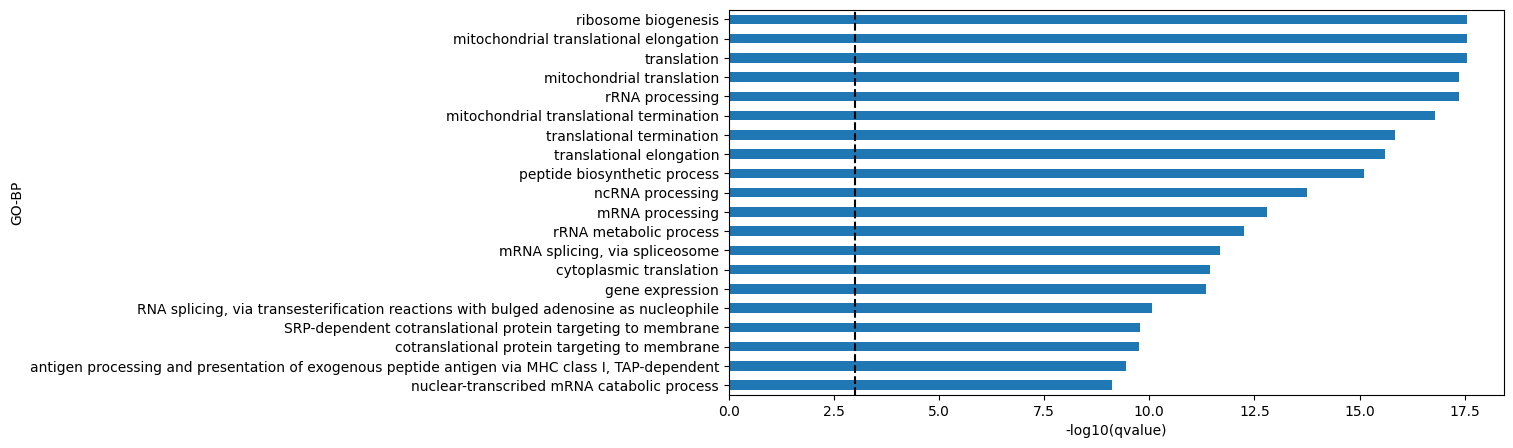

Query_HNOCA
2481 de genes


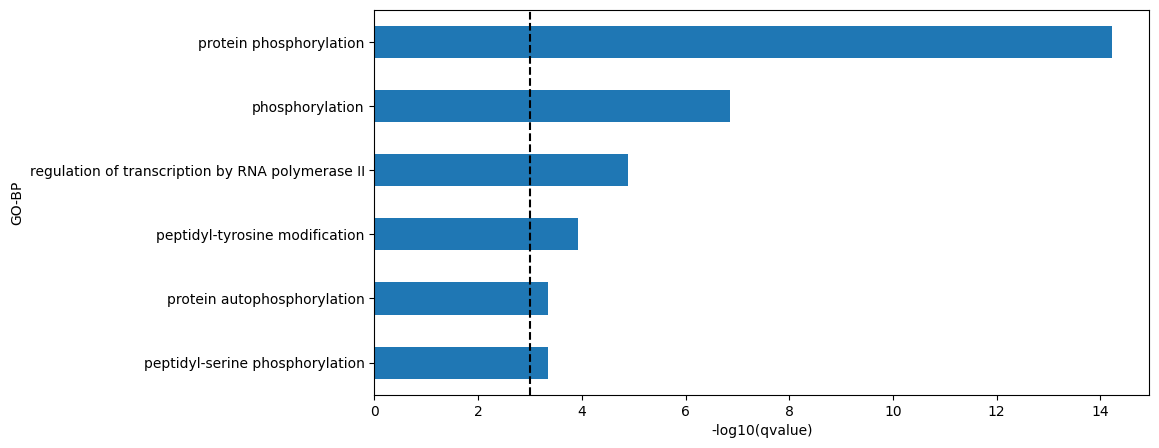

In [177]:
enr_upregulated = {}
for key in results_up.keys():
    print(key)
    enr_upregulated[key] = enrichr(results_up[key].index, background=cleaned_features, nterms=20, save_title="opc_upregulated", sample=key)

In [178]:
with pd.ExcelWriter(f"/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/03_transcriptomic_correlation/enrichr/opc_up.xlsx", engine='xlsxwriter') as writer:
    for sheet_name, df in enr_upregulated.items():
        # Check if the dataframe is not None and not empty
        if df is not None and not df.empty:
            df.to_excel(writer, sheet_name=sheet_name)

computing score 'Hallmark_Glycolysis'
    finished: added
    'Hallmark_Glycolysis', score of gene set (adata.obs).
    1186 total control genes are used. (0:00:02)


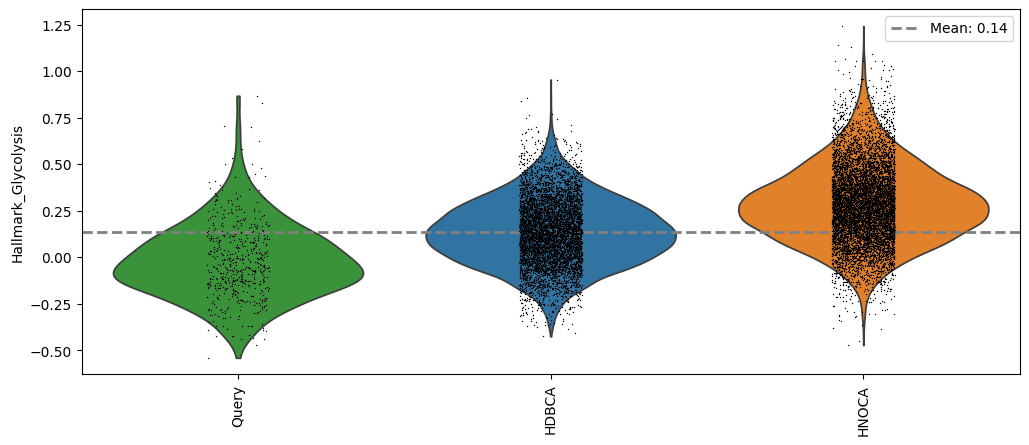

In [182]:
opc.X = opc.layers['log1p_norm'].copy()
glyco.compute_glycolysis_score(opc)
order = list(opc.obs['dataset'].unique())

plt.rcParams['figure.figsize']=(10,5)
# Draw the violin plot
ax = sc.pl.violin(opc, keys='Hallmark_Glycolysis', groupby='dataset', log=False, rotation=90, order=order, show=False)

# Calculate the mean value of the 'Hallmark_Glycolysis' data
mean_value = opc[opc.obs['dataset']=="HDBCA"].obs['Hallmark_Glycolysis'].mean()
# Add a dashed line at the mean value
plt.axhline(mean_value, color='grey', linestyle='--', linewidth=2, label=f"Mean: {mean_value:.2f}")
plt.legend()
plt.savefig('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/figures/03d_transcriptomic_fidelity/Glycolysis_opc.pdf', bbox_inches="tight")
plt.show()

## Repeat for glioblasts

In [15]:
query = query[:,joint_genes]
q_glio = query[query.obs['final_annot_level_1'].isin(["Glioblast"])].copy()
q_glio.X = q_glio.layers['counts'].copy()
q_glio.var_names_make_unique()
q_glio.obs_names_make_unique()
q_glio

AnnData object with n_obs × n_vars = 2710 × 21543
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_res_1', 'leiden_res_2', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'leiden_diffmap_res_4', 'snapseed_level_1', 'snapseed_level_2', 'snapseed_level_3', 'snapseed_level_4', 'snapseed_level_5', 'leiden_res_0.5', 'hnoca_level_1', 'hnoca_level_1_score', 'hnoca_level_1_logscore', 'hnoca_level_2', 'hnoca_level_2_score', 'hnoca_level_2_logscore', 'hnoca_level_3', 'hnoca_level_3_score', 'hnoca_level_3_logscore', 'hnoca_level_4', 'hnoca_level_4_score', 'hnoca_level_4_logscore', 'hdbca_

In [13]:
atlas = atlas[:,joint_genes]
a_glio = atlas[atlas.obs['CellClass']=='Glioblast']
a_glio.X = a_glio.layers['counts'].copy()
a_glio.var_names_make_unique()
a_glio.obs_names_make_unique()
a_glio

AnnData object with n_obs × n_vars = 132420 × 21543
    obs: 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'dissection', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'GeneTotalUMIs', 'Start', 'Gene'
    uns: 'batch_condition', 'log1p', 'neighbors', 'pca', 'title', 'umap'
    obsm: 'Factors', 'X_Embedding', 'X_pca', 'X_umap'
    varm: 'Loadings', 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [14]:
hnoca = hnoca[:,joint_genes]
h_glio = hnoca[hnoca.obs['annot_level_1']=='Glioblast']
h_glio.layers['counts'] = np.round(h_glio.layers['counts_lengthnorm']).copy()
del h_glio.layers['counts_lengthnorm']
h_glio.X = h_glio.layers['counts'].copy()
h_glio.var_names_make_unique()
h_glio.obs_names_make_unique()
h_glio

/scratch/28768602/ipykernel_2324407/3231485695.py:3: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  h_glio.layers['counts'] = np.round(h_glio.layers['counts_lengthnorm']).copy()


AnnData object with n_obs × n_vars = 79506 × 21543
    obs: 'assay_differentiation', 'assay_sc', 'assay_sc_original', 'assay_type_differentiation', 'bio_sample', 'cell_line', 'cell_line_original', 'cell_type', 'cell_type_original', 'development_stage', 'disease', 'disease_original', 'ethnicity', 'ethnicity_original', 'gm', 'id', 'individual', 'organ', 'organ_original', 'organism', 'organism_original', 'sample_source', 'sex', 'sex_original', 'state_exact', 'suspension_type', 'suspension_type_original', 'tech_sample', 'treatment', 'obs_names_original', 'organoid_age_days', 'publication', 'doi', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'annot_level_1', 'annot_level_2', 'annot_level_3_rev2', 'annot_level_4_rev2', 'annot_region_rev2', 'annot_ntt_rev2', 'Hallmark_Glycolysis'
    var: 'ensembl', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dr

In [17]:
q_glio.obs['dataset'] = "Query"
a_glio.obs['dataset'] = 'HDBCA'
h_glio.obs['dataset'] = "HNOCA"
glio = q_glio.concatenate([a_glio, h_glio])
glio

AnnData object with n_obs × n_vars = 214636 × 21543
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_res_1', 'leiden_res_2', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'leiden_diffmap_res_4', 'snapseed_level_1', 'snapseed_level_2', 'snapseed_level_3', 'snapseed_level_4', 'snapseed_level_5', 'leiden_res_0.5', 'hnoca_level_1', 'hnoca_level_1_score', 'hnoca_level_1_logscore', 'hnoca_level_2', 'hnoca_level_2_score', 'hnoca_level_2_logscore', 'hnoca_level_3', 'hnoca_level_3_score', 'hnoca_level_3_logscore', 'hnoca_level_4', 'hnoca_level_4_score', 'hnoca_level_4_logscore', 'hdbc

In [18]:
# Remove any genes located on the X and Y Chromosome or expressed in less than 1% of organoids cells
non_xy_genes = [gene for gene in glio.var.index if gene not in xy_genes['hgnc_symbol'].values]

n_cells = (glio.X > 0).sum(axis=0)
one_perc_genes = glio.var.iloc[np.where(n_cells.A.ravel() > round(0.01*glio.n_obs))[0]].index.tolist()

cleaned_features = sorted(list(set(one_perc_genes) & set(non_xy_genes)))

In [19]:
len(cleaned_features)

13392

In [20]:
glio = glio[:,cleaned_features]

In [23]:
glio

View of AnnData object with n_obs × n_vars = 214636 × 13392
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_res_1', 'leiden_res_2', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'leiden_diffmap_res_4', 'snapseed_level_1', 'snapseed_level_2', 'snapseed_level_3', 'snapseed_level_4', 'snapseed_level_5', 'leiden_res_0.5', 'hnoca_level_1', 'hnoca_level_1_score', 'hnoca_level_1_logscore', 'hnoca_level_2', 'hnoca_level_2_score', 'hnoca_level_2_logscore', 'hnoca_level_3', 'hnoca_level_3_score', 'hnoca_level_3_logscore', 'hnoca_level_4', 'hnoca_level_4_score', 'hnoca_level_4_logscore

In [27]:
for key in glio.obs_keys():
    glio.obs[key] = glio.obs[key].astype(str)

In [28]:
glio.write_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/03_transcriptomic_correlation/merged_glioblast.h5ad')

In [67]:
glio = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/03_transcriptomic_correlation/merged_glioblast.h5ad')

### Pseudobulk and edgeR 

processing Query
matching cell counts to 3252
creating 3 pseudo-replicates
processing HDBCA
matching cell counts to 3252
creating 3 pseudo-replicates
processing HNOCA
matching cell counts to 3252
creating 3 pseudo-replicates
normalizing counts per cell
    finished (0:00:00)
creating pseudobulk using dataset as sample_col
and sum as mode


dataset batch_rep singlets hnoca_leiden_level_1  \
HDBCA_HDBCA_0   HDBCA   HDBCA_0      nan                  nan   
HDBCA_HDBCA_1   HDBCA   HDBCA_1      nan                  nan   
HDBCA_HDBCA_2   HDBCA   HDBCA_2      nan                  nan   
HNOCA_HNOCA_0   HNOCA   HNOCA_0      nan                  nan   
HNOCA_HNOCA_1   HNOCA   HNOCA_1      nan                  nan   
HNOCA_HNOCA_2   HNOCA   HNOCA_2      nan                  nan   
Query_Query_0   Query   Query_0  Singlet            Glioblast   
Query_Query_1   Query   Query_1  Singlet            Glioblast   
Query_Query_2   Query   Query_2  Singlet            Glioblast   

              hnoca_leiden_level_2 hnoca_leiden_level_3 hnoca_leiden_level_4  \
HDBCA_HDBCA_0                  nan                  nan                  nan   
HDBCA_HDBCA_1                  nan                  nan                  nan   
HDBCA_HDBCA_2                  nan                  nan                  nan   
HNOCA_HNOCA_0                  nan                  nan                  nan   
HNOCA_HNOCA_1                  nan                  nan                  nan   
HNOCA_HNOCA_2                  nan                  nan                  nan   
Query_Query_0            Glioblast            Glioblast            Glioblast   
Query_Query_1            Glioblast            Glioblast            Glioblast   
Query_Query_2            Glioblast            Glioblast            Glioblast   

              reannotation            consensus consensus_count  ...  \
HDBCA_HDBCA_0          nan                  nan             nan  ...   
HDBCA_HDBCA_1          nan                  nan             nan  ...   
HDBCA_HDBCA_2          nan                  nan             nan  ...   
HNOCA_HNOCA_0          nan                  nan             nan  ...   
HNOCA_HNOCA_1          nan                  nan             nan  ...   
HNOCA_HNOCA_2          nan                  nan             nan  ...   
Query_Query_0    Glioblast  consensus Glioblast             4.0  ...   
Query_Query_1    Glioblast  consensus Glioblast             4.0  ...   
Query_Query_2    Glioblast  consensus Glioblast             4.0  ...   

              annot_level_3_rev2 annot_level_4_rev2 annot_region_rev2  \
HDBCA_HDBCA_0                nan                nan               nan   
HDBCA_HDBCA_1                nan                nan               nan   
HDBCA_HDBCA_2                nan                nan               nan   
HNOCA_HNOCA_0          Glioblast          Glioblast        Unspecific   
HNOCA_HNOCA_1          Glioblast          Glioblast        Unspecific   
HNOCA_HNOCA_2          Glioblast          Glioblast        Unspecific   
Query_Query_0                nan                nan               nan   
Query_Query_1                nan                nan               nan   
Query_Query_2                nan                nan               nan   

              annot_ntt_rev2 replicate psbulk_n_cells psbulk_counts  \
HDBCA_HDBCA_0            nan         0         1084.0     8106285.0   
HDBCA_HDBCA_1            nan         1         1084.0     8634058.0   
HDBCA_HDBCA_2            nan         2         1084.0     8518611.0   
HNOCA_HNOCA_0            nan         0         1084.0     8359289.0   
HNOCA_HNOCA_1            nan         1         1084.0     8545584.0   
HNOCA_HNOCA_2            nan         2         1084.0     8488701.0   
Query_Query_0            nan         0          904.0    10696312.0   
Query_Query_1            nan         1          903.0    10683385.0   
Query_Query_2            nan         2          903.0    10829120.0   

              log_psbulk_counts n_genes_median  n_genes_std  
HDBCA_HDBCA_0         15.908150         2670.5  1263.609320  
HDBCA_HDBCA_1         15.971225         2790.5  1274.034140  
HDBCA_HDBCA_2         15.957764         2750.5  1274.958922  
HNOCA_HNOCA_0         15.938884         2148.5  1222.439638  
HNOCA_HNOCA_1         15.960925         2069.0  1228.203534  
HNOCA_HNOCA_2         15.95

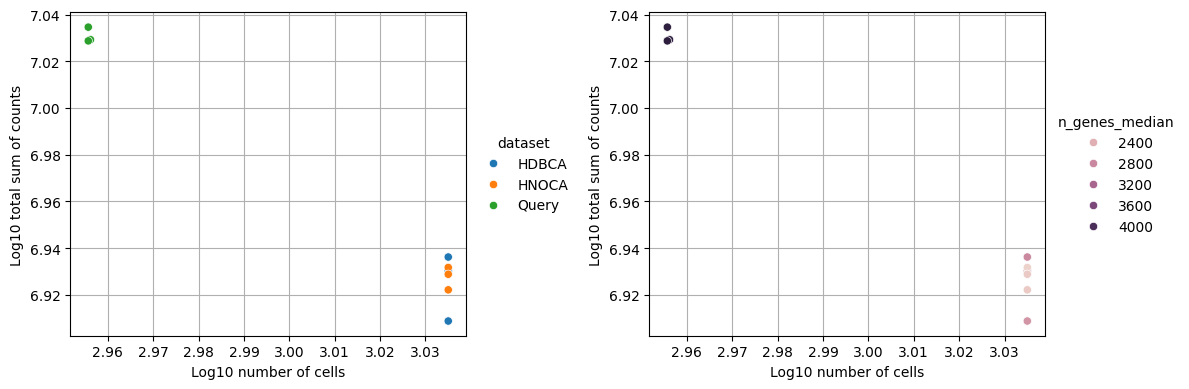

In [29]:
pdata = create_pseudobulk(glio, batch_column='dataset', replicates=3, matched=True, mode='sum')
pdata.obs

In [30]:
pdata.obs['replicate'] = pdata.obs['replicate'].astype(str)
pdata.write('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/03_transcriptomic_correlation/merged_glioblast_pseudobulk.h5ad')

In [43]:
pdata = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/03_transcriptomic_correlation/merged_glioblast_pseudobulk.h5ad')

In [72]:
a_glio = atlas[atlas.obs['CellClass']=="Glioblast"]

In [75]:
a_glio.X = a_glio.layers['counts']

In [52]:
glio.X = glio.layers['counts'].copy()

In [ ]:
sc.pp.highly_variable_genes(a_glio, n_top_genes=3000, batch_key="donor_id", flavor='seurat_v3')

In [64]:
sc.pp.highly_variable_genes(glio[glio.obs['dataset']=="HDBCA"], n_top_genes=3000, batch_key="donor_id", flavor='seurat_v3')

In [ ]:
glio.X = glio.layers['']

In [ ]:
mat1 = glio[glio.obs['dataset']=="HDBCA",glio.var['highly_variable']].X.T()
mat2 = glio[glio.obs['dataset']=="Query",glio.var['highly_variable']].X.T()

In [ ]:
column_pairs = [(mat1.getcol(i), mat2.getcol(i)) for i in range(mat1.shape[1])]

In [44]:
# Initialize a list to store correlation results
correlation_results = []

# Loop through each model dataset
for dataset in glio.obs['dataset'].unique():
    if dataset == "HDBCA":
        hdbca_data = glio[glio.obs['dataset']=="HDBCA"].X.mean(axis=0) 
        continue
    print(dataset)
    
    model_data = glio[glio.obs['dataset']== dataset].X.mean(axis=0)

    # Compute correlations for each replicate in the model
    for replicate in pdata.obs['replicate'][pdata.obs['dataset'] == dataset]:
        print(replicate)
        replicate_data = model_data[model_data.obs['replicate'] == replicate].X.mean(axis=0)
        correlation = np.corrcoef(replicate_data, hdbca_data)[0, 1]  # Compute Pearson correlation
        # Store the result
        correlation_results.append({'Dataset': dataset, 'Replicate': replicate, 'Correlation': correlation})

# Convert to a DataFrame for visualization
correlation_glioblast = pd.DataFrame(correlation_results)

HNOCA
0
1
2
Query
0
1
2


In [45]:
correlation_glioblast['sample'] = "Glioblast"
correlation_glioblast

Dataset Replicate  Correlation     sample
0   HNOCA         0     0.953797  Glioblast
1   HNOCA         1     0.953061  Glioblast
2   HNOCA         2     0.951291  Glioblast
3   Query         0     0.920158  Glioblast
4   Query         1     0.920562  Glioblast
5   Query         2     0.921909  Glioblast

In [185]:
pdata.obs['replicate'] = pdata.obs['replicate'].astype(int)+1

In [184]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

covariates = pdata.obs[["psbulk_n_cells", "psbulk_counts", "n_genes_median", "n_genes_std", 'log_psbulk_counts']]
correlation_matrix = covariates.corr()
print(correlation_matrix)  # Check pairwise correlations

vif = pd.DataFrame()
vif["features"] = covariates.columns
vif["VIF"] = [variance_inflation_factor(covariates.values, i) for i in range(covariates.shape[1])]
print(vif)

                   psbulk_n_cells  psbulk_counts  n_genes_median  n_genes_std  \
psbulk_n_cells           1.000000      -0.991220       -0.959745    -0.972032   
psbulk_counts           -0.991220       1.000000        0.949639     0.960808   
n_genes_median          -0.959745       0.949639        1.000000     0.990258   
n_genes_std             -0.972032       0.960808        0.990258     1.000000   
log_psbulk_counts       -0.988898       0.999831        0.946947     0.958616   

                   log_psbulk_counts  
psbulk_n_cells             -0.988898  
psbulk_counts               0.999831  
n_genes_median              0.946947  
n_genes_std                 0.958616  
log_psbulk_counts           1.000000  
            features           VIF
0     psbulk_n_cells  12348.138876
1      psbulk_counts   6046.020402
2     n_genes_median    650.639194
3        n_genes_std  11898.958543
4  log_psbulk_counts  52872.602731


In [186]:
r_edger_fit(pdata)

[1] "(Intercept)"  "datasetHNOCA" "datasetQuery"


array(['success'], dtype='<U7')

Testing coefficient: datasetQuery
[1] "datasetQuery"


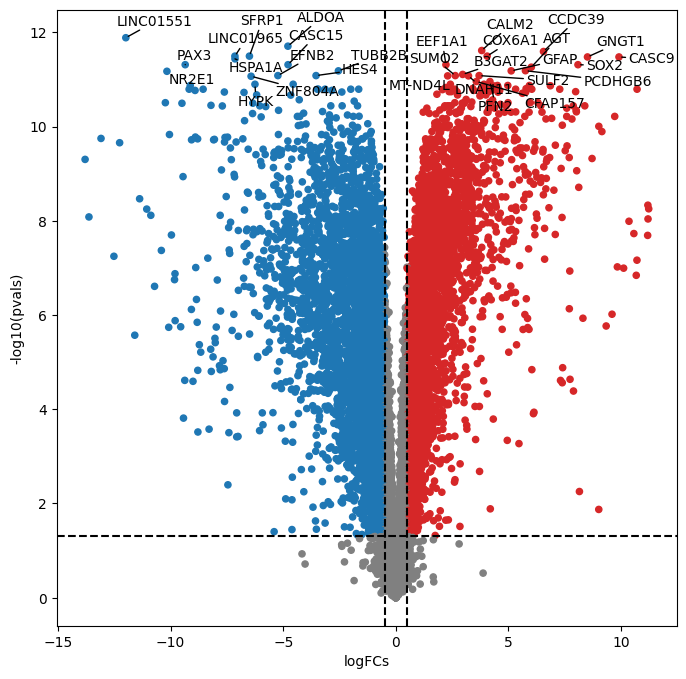

Testing coefficient: datasetHNOCA
[1] "datasetHNOCA"


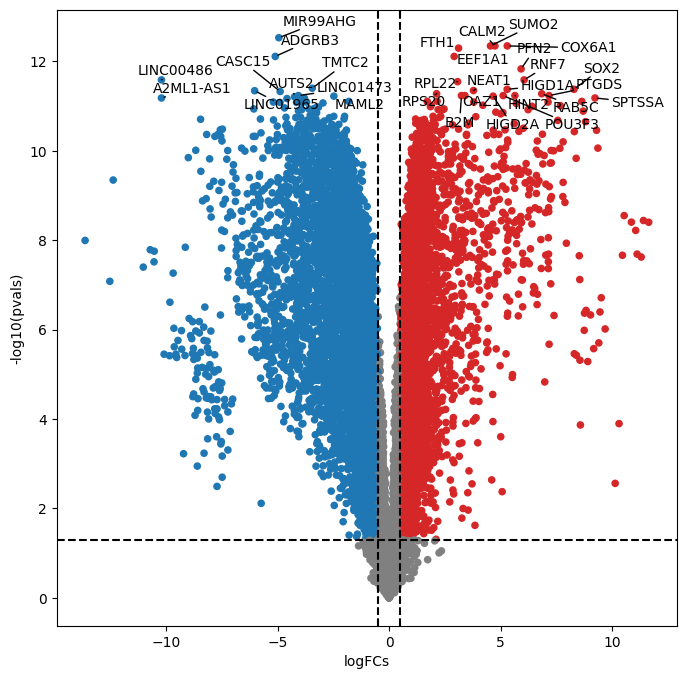

Testing contrast: datasetQuery - datasetHNOCA
[1] "datasetQuery - datasetHNOCA"


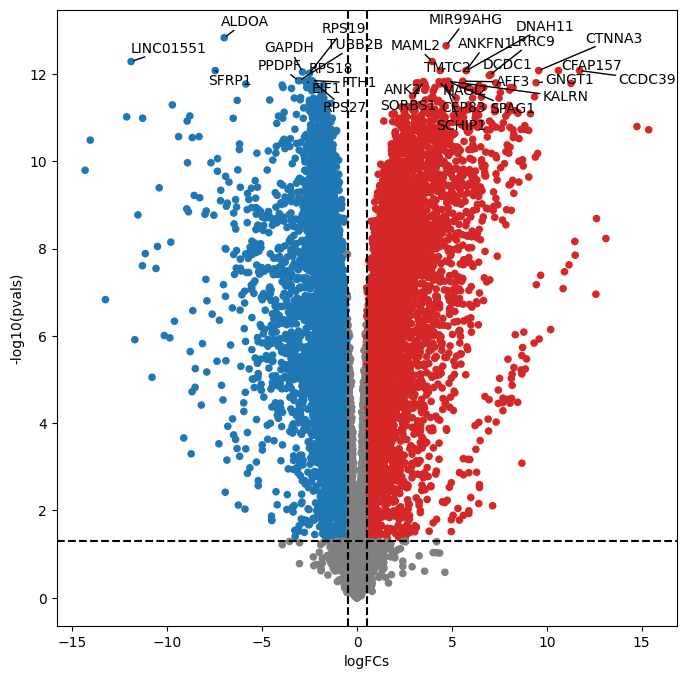

In [187]:
deg_q = edger_test(coef='datasetQuery', plot=True).sort_values("qval")
deg_h = edger_test(coef='datasetHNOCA', plot=True).sort_values("qval")
deg_hq = edger_test(contrast="datasetQuery - datasetHNOCA", plot=True).sort_values('qval')

### Clean results

In [188]:
results = {'HDBCA_Query':deg_q,
    "HDBCA_HNOCA":deg_h,
    "Query_HNOCA":deg_hq,}

In [193]:
results_cleaned, results_up, results_down = get_sig_results(results, qval_thres=0.05, lfc_abs_thres=0.5)

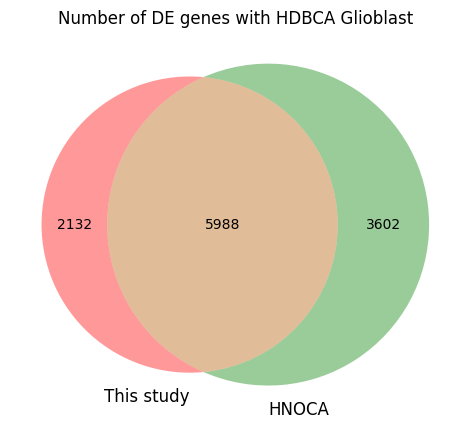

In [194]:
venn2((set(results_cleaned["HDBCA_Query"].index), set(results_cleaned['HDBCA_HNOCA'].index)), set_labels=("This study","HNOCA"))
plt.title("Number of DE genes with HDBCA Glioblast")
plt.savefig('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/figures/03d_transcriptomic_fidelity/Venn_glioblast.pdf', bbox_inches="tight")
plt.show()

In [195]:
with pd.ExcelWriter(f"/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/03_transcriptomic_correlation/degs/Glioblasts.xlsx", engine='xlsxwriter') as writer:
    for i in results_cleaned:
        results_cleaned[i].to_excel(writer, sheet_name=i)

In [190]:
# number of genes with aligned direction out of the shared DEGS
shared_degs = list(set(results_cleaned["HDBCA_Query"].index) & set(results_cleaned["HDBCA_HNOCA"].index))
shared_direction = np.sign(results_cleaned["HDBCA_Query"].loc[shared_degs, "log2fc"]) == np.sign(results_cleaned["HDBCA_HNOCA"].loc[shared_degs, "log2fc"])
shared_direction.value_counts()

log2fc
True     1161
False     617
Name: count, dtype: int64

In [196]:
len(pdata.var)-2132-5988-3602

1670

In [197]:
#odds ratio and contingency table for the overlap
contingency_table = [
    [5988, 3602],
    [2132, 1670]
]
odds_ratio, p_value = scipy.stats.fisher_exact(contingency_table)
odds_ratio, p_value

(1.3021690055451787, 1.2880431137621278e-11)

In [116]:
shared_aligned_degs, unique_degs = get_deg_overlap(results_cleaned, comparisons=results_cleaned.keys())

In [141]:
results_cleaned_unique, results_up, results_down = get_sig_results(unique_degs, qval_thres=0.05, lfc_abs_thres=0.5)

HDBCA_Query
1869 de genes


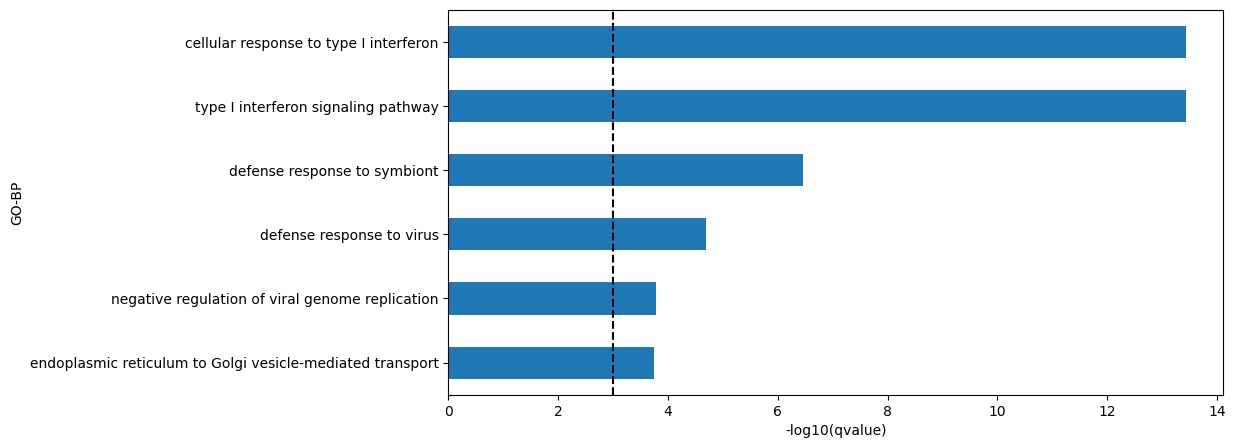

HDBCA_HNOCA
2665 de genes


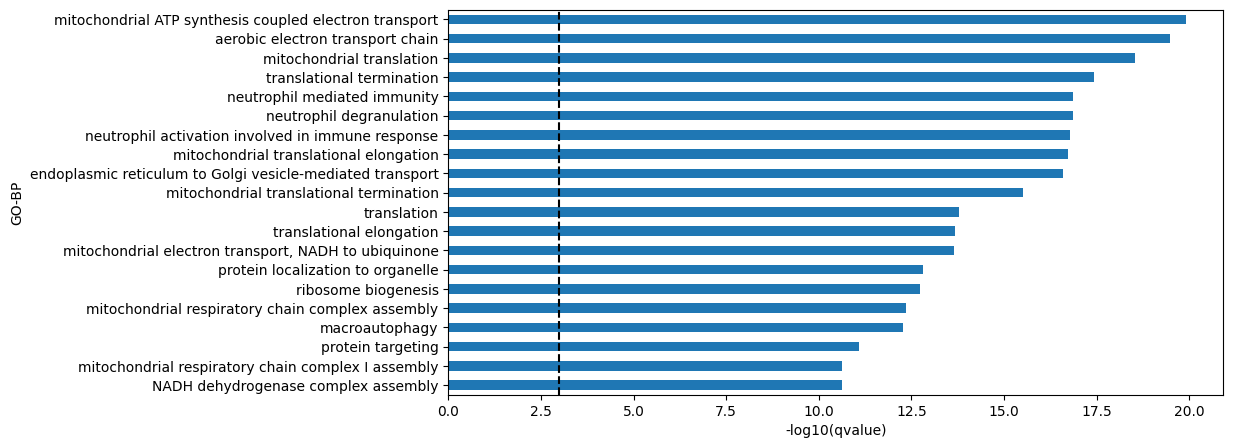

Query_HNOCA
2676 de genes
no significant results


In [142]:
enr_upregulated = {}
for key in results_up.keys():
    print(key)
    enr_upregulated[key] = enrichr(results_up[key].index, background=cleaned_features, nterms=20, save_title="glioblast_upregulated", sample=key)

In [147]:
with pd.ExcelWriter(f"/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/03_transcriptomic_correlation/enrichr/glioblast_up.xlsx", engine='xlsxwriter') as writer:
    for sheet_name, df in enr_upregulated.items():
        # Check if the dataframe is not None and not empty
        if df is not None and not df.empty:
            df.to_excel(writer, sheet_name=sheet_name)

HDBCA_Query
1809 de genes


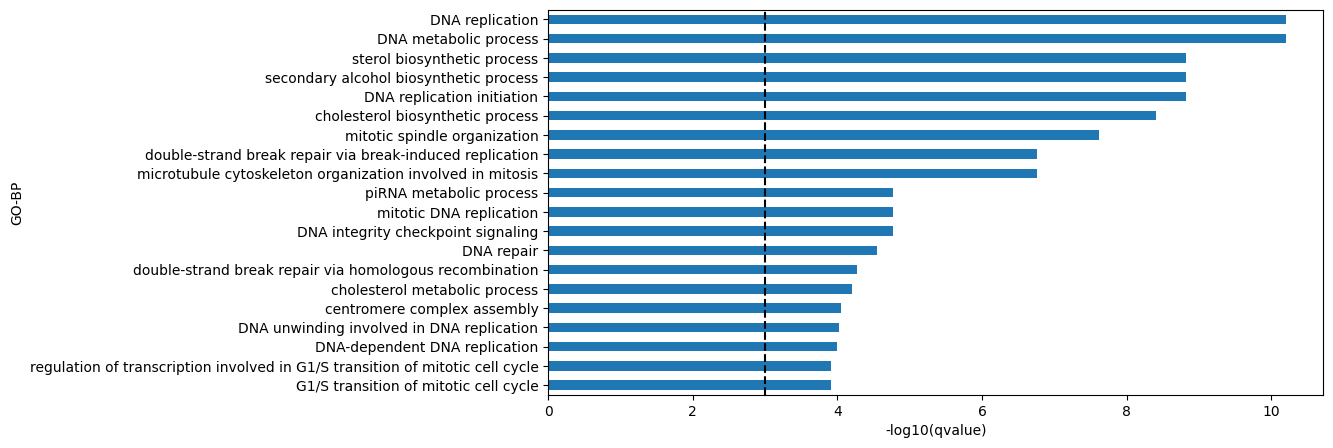

HDBCA_HNOCA
2483 de genes


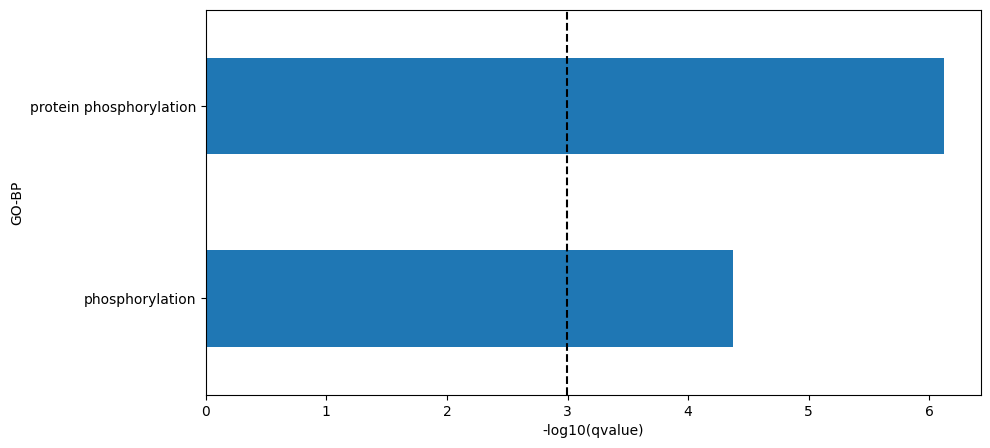

Query_HNOCA
2777 de genes


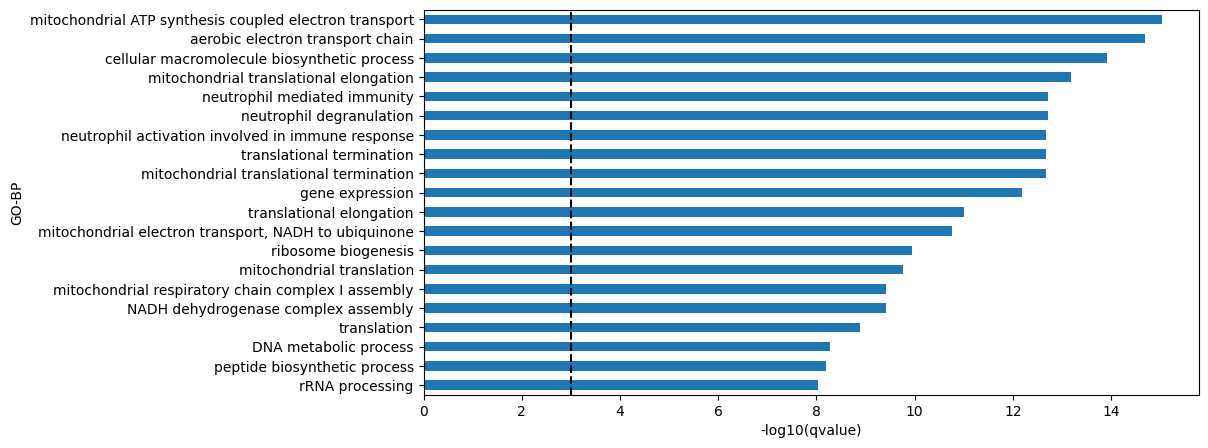

In [148]:
enr_downregulated = {}
for key in results.keys():
    print(key)
    enr_downregulated[key] = enrichr(results_down[key].index, background=cleaned_features, nterms=20, save_title="glioblast_downregulated", sample=key)

In [149]:
with pd.ExcelWriter(f"/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/03_transcriptomic_correlation/enrichr/glioblast_down.xlsx", engine='xlsxwriter') as writer:
    for sheet_name, df in enr_upregulated.items():
        # Check if the dataframe is not None and not empty
        if df is not None and not df.empty:
            df.to_excel(writer, sheet_name=sheet_name)

In [124]:
results_cleaned_unique, results_up, results_down = get_sig_results(shared_aligned_degs, qval_thres=0.05, lfc_abs_thres=0.5)

In [126]:
results_up.keys()

dict_keys(['HDBCA_Query', 'HDBCA_HNOCA', 'Query_HNOCA'])

HDBCA_Query
365 de genes


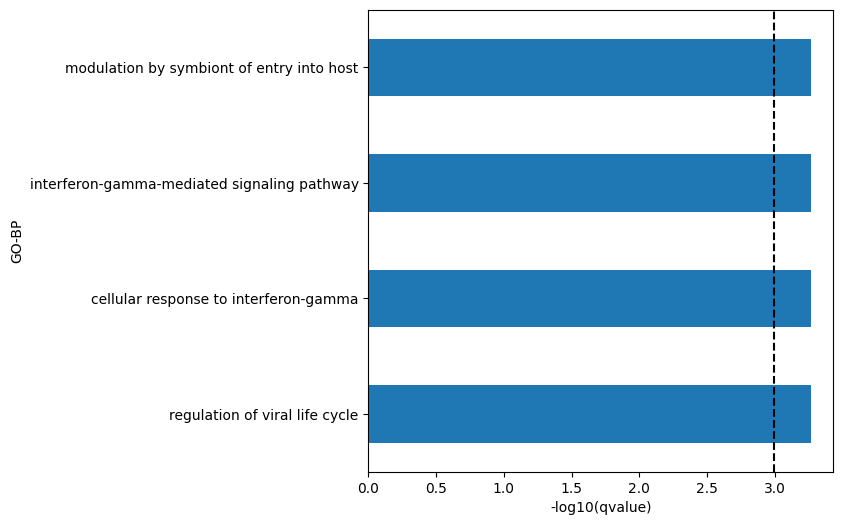

HDBCA_HNOCA
365 de genes


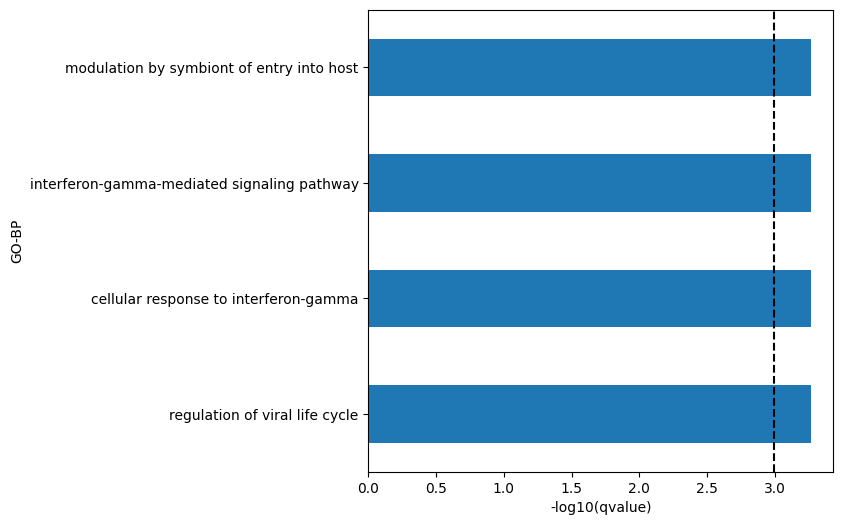

Query_HNOCA
365 de genes


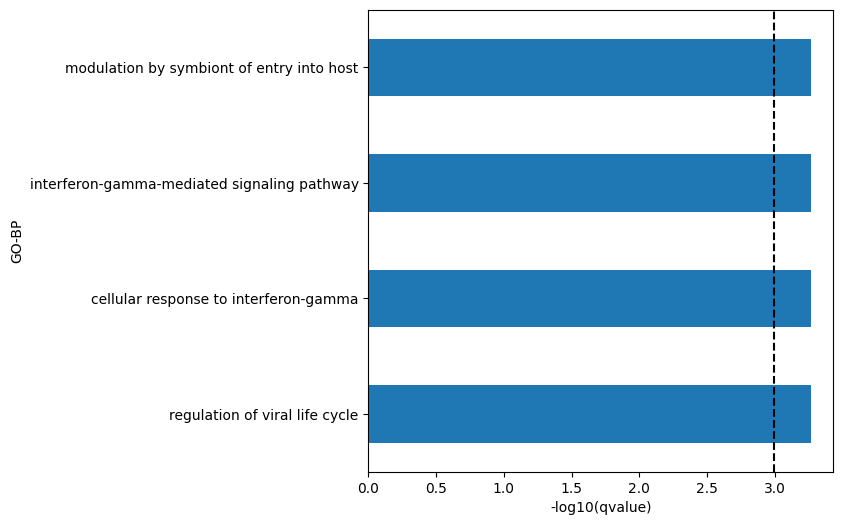

In [95]:
enr_upregulated = enrichr(results_up[key].index, background=cleaned_features, nterms=20)

HDBCA_Query


493 de genes


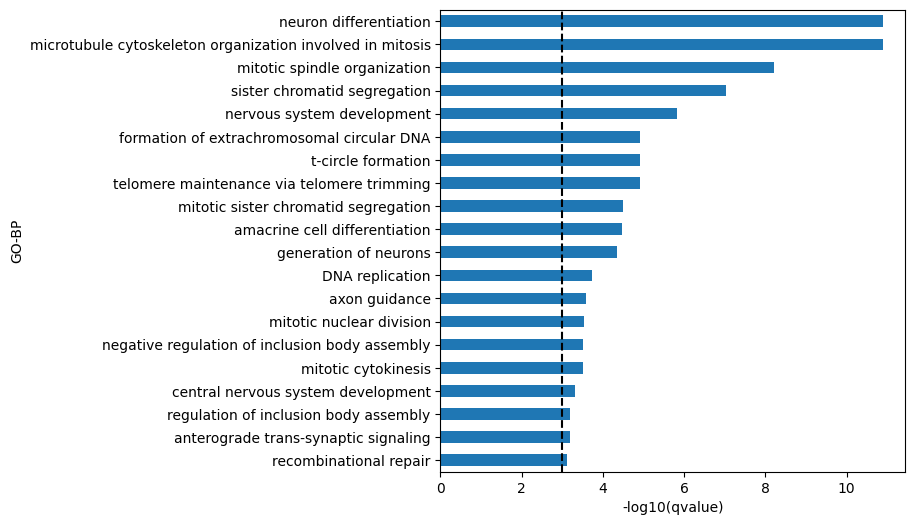

HDBCA_HNOCA
493 de genes


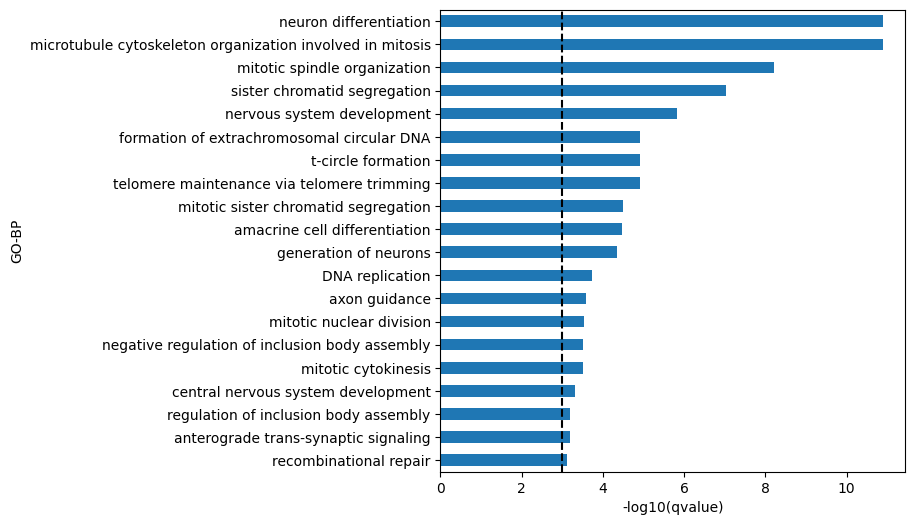

Query_HNOCA
493 de genes


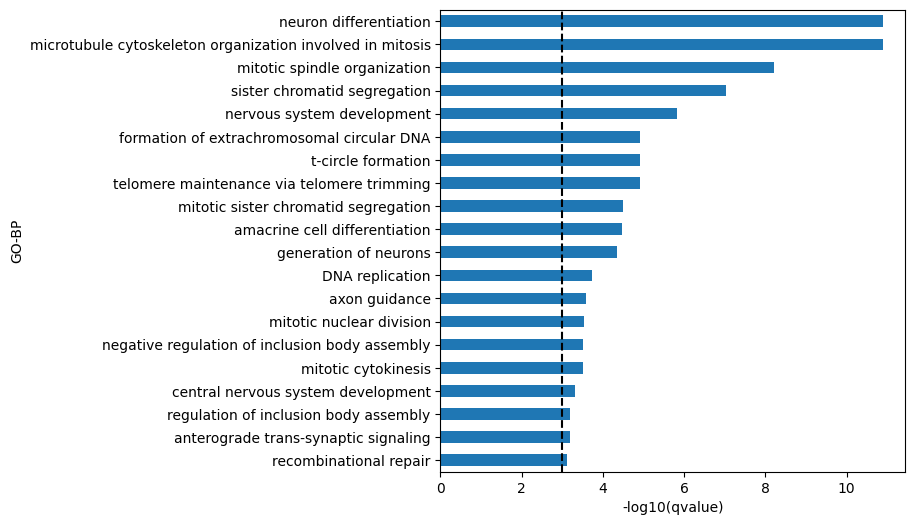

In [96]:
enr_downregulated = {}
for key in results.keys():
    print(key)
    enr_downregulated[key] = enrichr(results_down[key].index, background=cleaned_features, nterms=20)

In [103]:
sc.pp.normalize_total(glio)
sc.pp.log1p(glio)
glio.layers['log1p_norm'] = glio.X.copy()

normalizing counts per cell
    finished (0:01:33)
